In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm

%matplotlib inline


In [2]:
class ES:
    '''
    mode=0 for ES(µ + λ)
    mode=1 for ES(µ, λ)
    '''

    def __init__(self, mode, iters, mu, lambda_, chromosome_len, eval_f, domain_l=0, domain_r=1, K=0.6, boost=False, tau0=None, tau1=None):
        self.mode = mode
        self.iters = iters
        self.mu = mu
        self.lambda_ = lambda_
        self.d = chromosome_len
        self.eval_f = eval_f
        self.K = K
        self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))
        self.tau1 = K / np.sqrt(2 * self.d)
        self.domain_l = domain_l
        self.domain_r = domain_r
        self.cost_history = []
        self.best_sigmas_history = []
        self.boost = boost

    def random_population(self):
        pop = [(self.domain_l + (self.domain_r-self.domain_l)*np.random.rand(self.d), np.ones(self.d).astype(float)) for _ in range(self.mu)]
        return np.array(pop)

    def parents_selection(self, pop_v):
        if np.sum(np.abs(pop_v)) == 0:
            prop = np.ones(len(pop_v)) / len(pop_v)
        else:
            prop = np.abs(pop_v) / (np.sum(np.abs(pop_v)))  # normalization
         
        parents_idx = np.zeros(self.lambda_)
        for i in range(self.lambda_):
            parents_idx[i] = np.random.choice(
                np.arange(len(prop)), p=prop)  # roulette

        return parents_idx.astype(int)

    def mutation(self, x):
        x_v = x[0].copy()
        sigma_v = x[1].copy()
        eps0 = np.random.normal(0, self.tau0)
        eps_v = np.array([np.random.normal(0, self.tau1) +
                          eps0 for _ in range(len(sigma_v))])
        sigma_v = np.exp(eps_v) * sigma_v
        x_v = np.array([x + np.random.normal(0, sigma)
                        for (x, sigma) in zip(x_v, sigma_v)])

        return (x_v, sigma_v)

    def best_idx(self, p_v):
        return np.argpartition(p_v, self.mu)[:self.mu]

    def run(self):
        scores = np.zeros(self.iters)
        p = self.random_population()
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode]

        for t in tqdm(range(self.iters), desc=f'{desc}'):
            pop_v = np.array([self.eval_f(x) for (x, sigma) in p])
            parents_idx = self.parents_selection(pop_v)
            children = p[parents_idx]

            if self.boost:
                children =[]
                for i in range(len(parents_idx)):
                    children.append(np.array(
                        [p[parents_idx[:i+1]][:, 0].mean(axis=0), p[parents_idx[:i+1]][:, 1].mean(axis=0)]))

            children = np.array(children)
            children = np.array([self.mutation(c) for c in children])

            if self.mode == 0:
                candidates = np.concatenate((children, p))
            else:
                candidates = children

            candidates[:, 0][candidates[:, 0] < self.domain_l] = self.domain_l
            candidates[:, 0][candidates[:, 0] > self.domain_r] = self.domain_r
            candidates_v = np.array([self.eval_f(x) for (x, sigma) in candidates])
            p = candidates[self.best_idx(candidates_v)]

            self.cost_history.append((candidates_v.min(), candidates_v.mean(), candidates_v.max()))
            best_guy = candidates_v.argmin()
            self.best_sigmas_history.append(
                candidates[:, 1][best_guy])  # sigmas of best guy in population
            scores[t] = candidates_v.min()
        return scores

    def plot_cost(self):
        self.cost_history = np.array(self.cost_history)
        plt.figure(figsize=(15, 5))
        plt.plot(self.cost_history)
        best_id = self.cost_history[:, 0].argmin()
        best_val = self.cost_history[:, 0][best_id]
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode]
        plt.title(f'{desc} POPULATION SIZE: {self.mu}  |  CHROMOSOME LEN: {self.d}  |  ITERS: {self.iters} |  BEST: {best_val :.3f}')
        plt.legend(['Min', 'Mean', 'Max'], loc='upper right')

    def plot_sigmas(self, sigmas):
        plt.figure(figsize=(15, 5))
        plt.title('Sigmas')
        plt.plot(sigmas)
        plt.show()


# Benchmarks:

In [4]:
def griewank(X):
    return 1 + 1/4000 * np.sum(X**2) - np.prod(np.cos(X/np.sqrt(np.arange(len(X))+1)))

def michalewicz(X):
    return -np.sum(np.sin(X)*np.sin((np.arange(len(X))+1)*(X**2)/np.pi)**6)

def sum_squares(X):
    return np.sum(X**2)

def rastrigin(X):
    return 10*len(X) + np.sum(X**2 - 10*np.cos(2*np.pi*X))

def dixon_price(X):
    a = X[:-1]
    b = X[1:]
    return ((X[0] - 1)**2 + np.sum((np.arange(len(b)) + 2)*((2*b**2-a)**2)))


In [5]:
def get_f(x, y, f):
    return f(np.array([x, y]))
    
def plot_3D_benchmark_function(f, domain_X, domain_Y, title):
    plt.figure(figsize=(15, 10))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    zs = np.array([get_f(x, y, f) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.gist_heat_r, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()


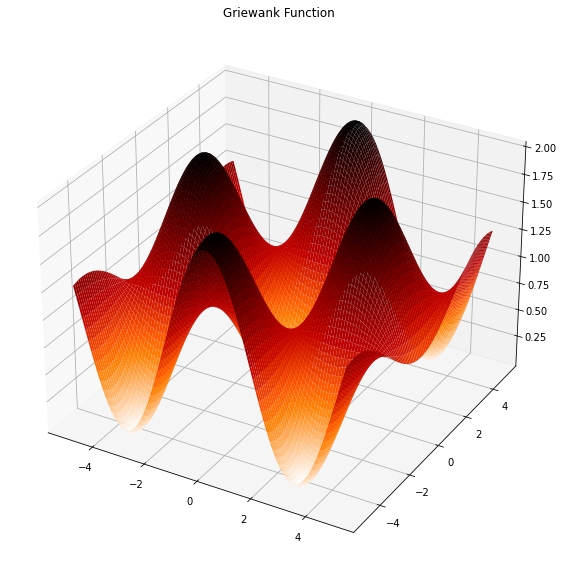

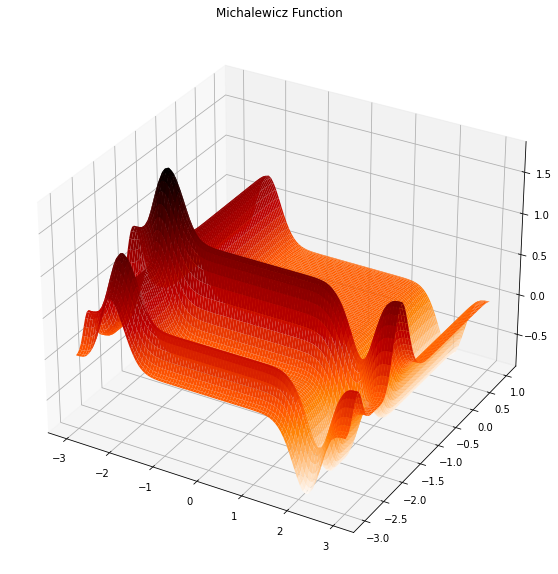

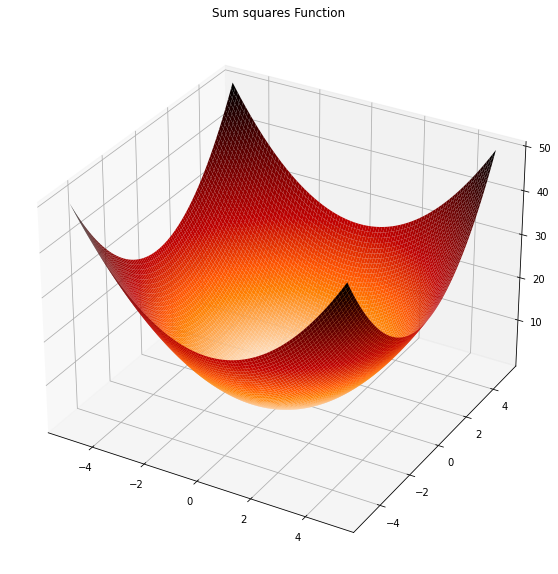

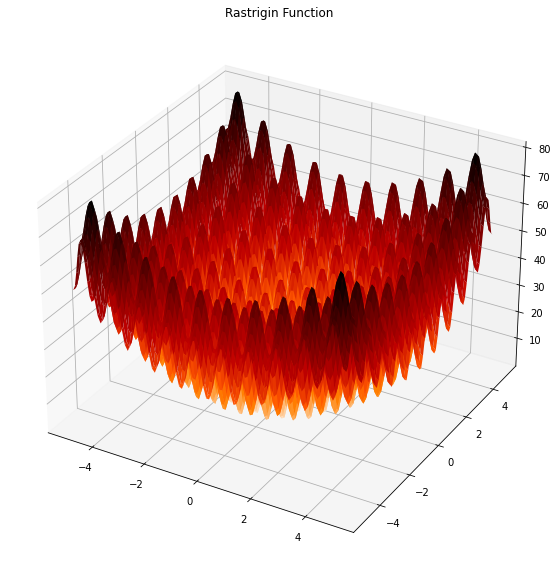

In [6]:
plot_3D_benchmark_function(
    griewank, np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Griewank Function')
plot_3D_benchmark_function(
    michalewicz, np.linspace(-3, 3, 100),  np.linspace(-3, 1, 100), 'Michalewicz Function')
plot_3D_benchmark_function(
    sum_squares, np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Sum squares Function')
plot_3D_benchmark_function(
    rastrigin, np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Rastrigin Function')
plot_3D_benchmark_function(
    dixon_price, np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Dixon-Price Function')


## Task 1b)

In [6]:
instances = [
    'Griewank Function', 
    (0, 500, 50, 100, 50, griewank, -600, 600, 0.2, False),
    (0, 500, 50, 100, 50, griewank, -600, 600, 0.2, True),
    (1, 1000, 100, 150, 50, griewank, -600, 600, 0.3, False),
    (0, 1000, 100, 150, 50, griewank, -600, 600, 0.3, False),
    'Michalewicz Function', 
    (0, 500, 50, 100, 10, michalewicz, 0, np.pi, 0.2, False),
    (0, 500, 50, 100, 10, michalewicz, 0, np.pi, 0.2, False, True),
    (1, 1000, 100, 150, 50, michalewicz, 0, np.pi, 0.25, False),
    (0, 1000, 100, 150, 50, michalewicz, 0, np.pi, 0.25, False),
    'Sum squares Function',
    (0, 500, 50, 100, 50, sum_squares, -10, 10, 0.2, False),
    (0, 500, 50, 100, 50, sum_squares, -10, 10, 0.2, True),
    (1, 1000, 100, 150, 100, sum_squares, -10, 10, 0.3, False),
    (0, 1000, 100, 150, 100, sum_squares, -10, 10, 0.3, False),
    'Rastrigin Function',
    (0, 500, 50, 100, 50, rastrigin, -5.12, 5.12, 0.2, False),
    (0, 500, 50, 100, 50, rastrigin, -5.12, 5.12, 0.2, True),
    (1, 1000, 100, 150, 50, rastrigin, -5.12, 5.12, 0.25, False),
    (0, 1000, 100, 150, 50, rastrigin, -5.12, 5.12, 0.25, False),
    'Dixon-Price Function',
    (0, 500, 50, 100, 50, dixon_price, -10, 10, 0.2, False),
    (0, 500, 50, 100, 50, dixon_price, -10, 10, 0.2, True),
    (1, 1000, 100, 150, 50, dixon_price, -10, 10, 0.3, False),
    (0, 1000, 100, 150, 50, dixon_price, -10, 10, 0.3, False),
]


ES(µ + λ):   1%|          | 3/500 [00:00<00:21, 22.73it/s]

Griewank Function


ES(µ + λ): 100%|██████████| 500/500 [00:16<00:00, 30.37it/s]


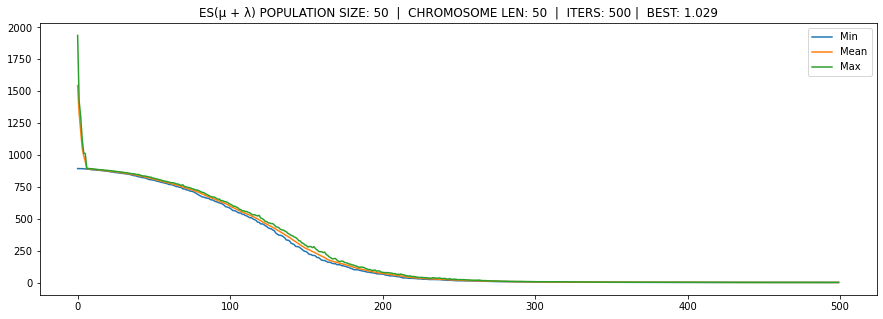

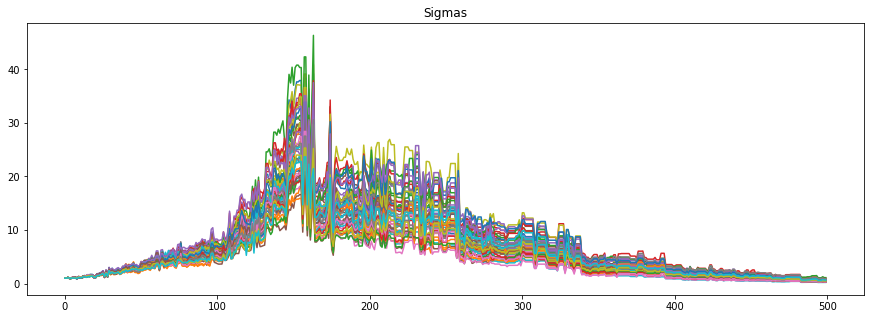

ES(µ + λ): 100%|██████████| 500/500 [00:18<00:00, 27.45it/s]


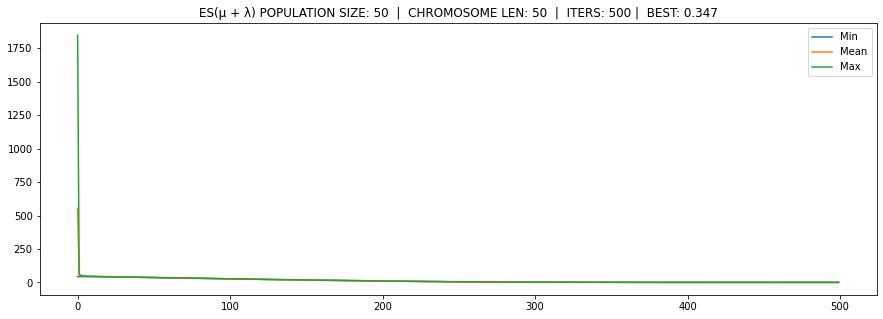

ES(µ, λ): 100%|██████████| 1000/1000 [00:55<00:00, 17.94it/s]


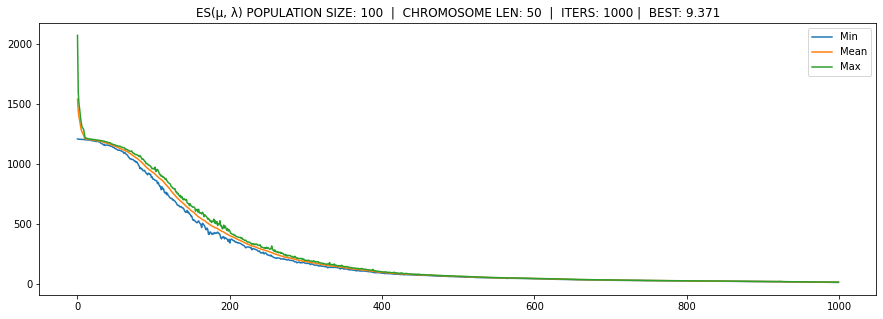

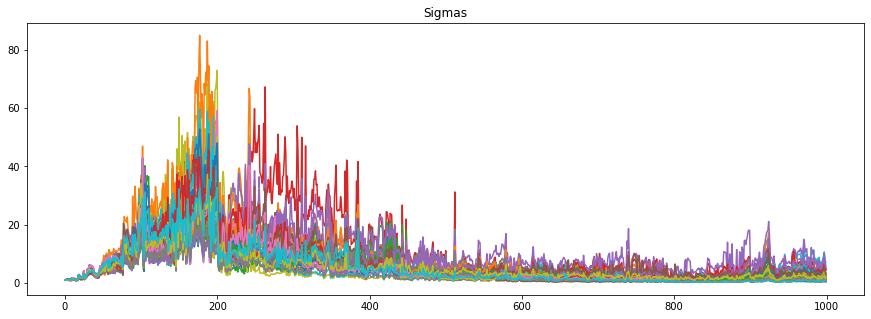

ES(µ + λ): 100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


ES(µ + λ):   1%|▏         | 7/500 [00:00<00:07, 67.83it/s]

Michalewicz Function


ES(µ + λ): 100%|██████████| 500/500 [00:05<00:00, 84.98it/s]


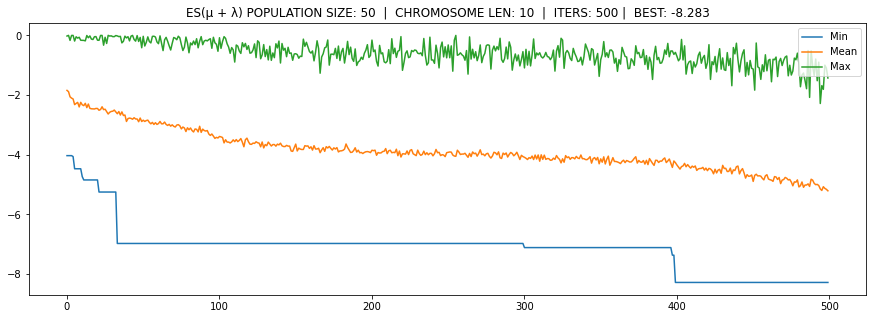

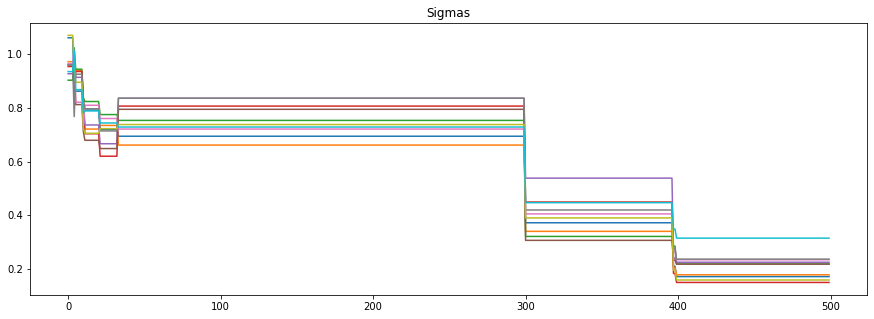

ES(µ + λ): 100%|██████████| 500/500 [00:05<00:00, 85.44it/s]


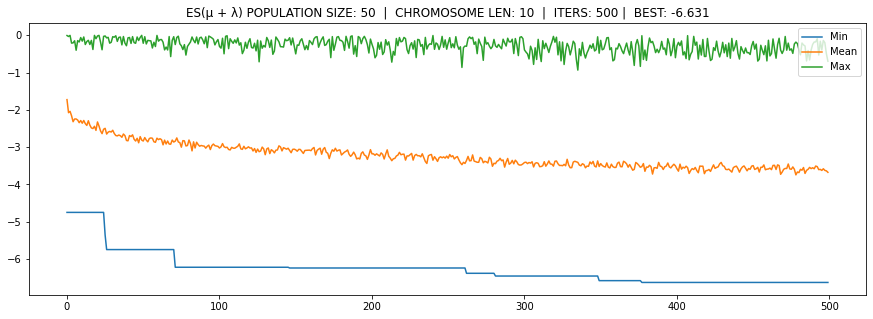

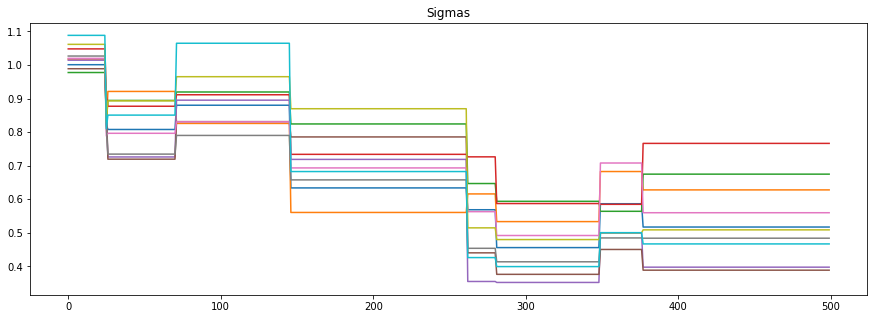

ES(µ, λ): 100%|██████████| 1000/1000 [00:52<00:00, 18.88it/s]


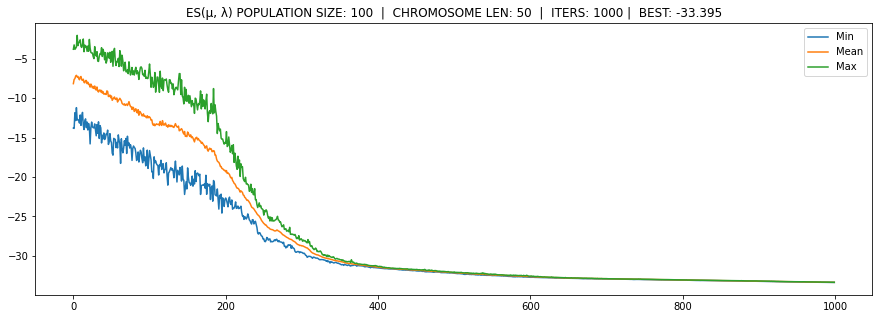

ES(µ + λ): 100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]


ES(µ + λ):   1%|          | 3/500 [00:00<00:22, 22.46it/s]

Sum squares Function


ES(µ + λ): 100%|██████████| 500/500 [00:18<00:00, 26.68it/s]


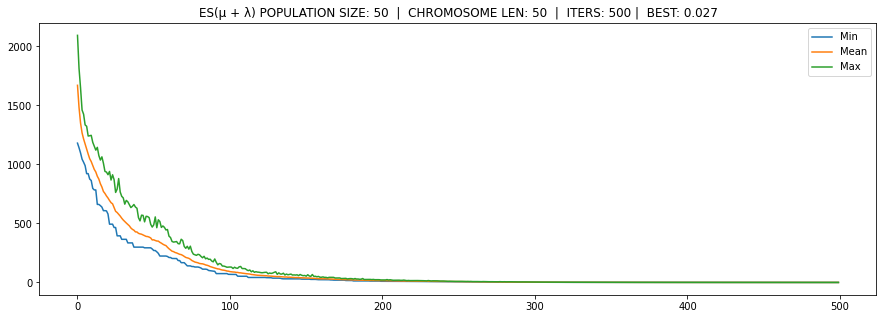

ES(µ + λ): 100%|██████████| 500/500 [00:18<00:00, 26.86it/s]


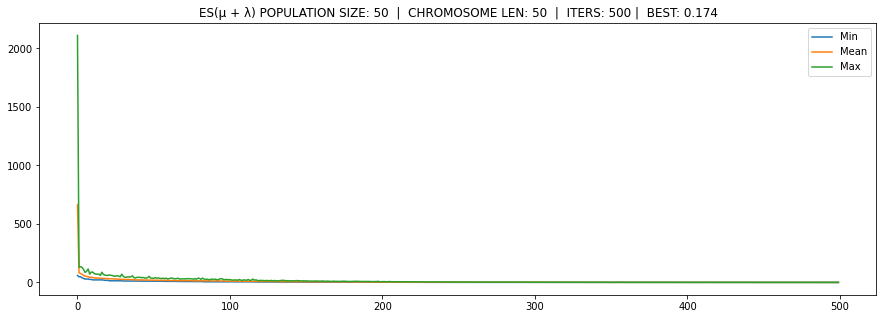

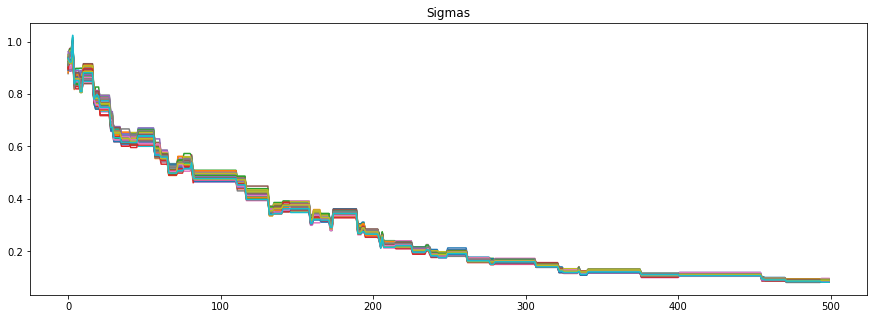

ES(µ, λ): 100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s]


ES(µ + λ): 100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


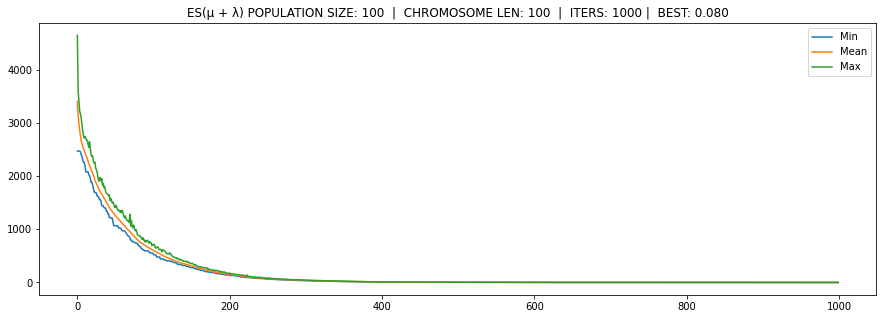

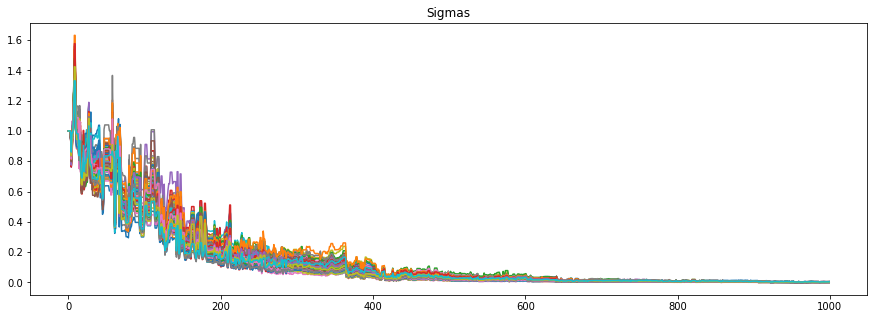

ES(µ + λ):   1%|          | 4/500 [00:00<00:14, 34.72it/s]

Rastrigin Function


ES(µ + λ): 100%|██████████| 500/500 [00:16<00:00, 29.93it/s]


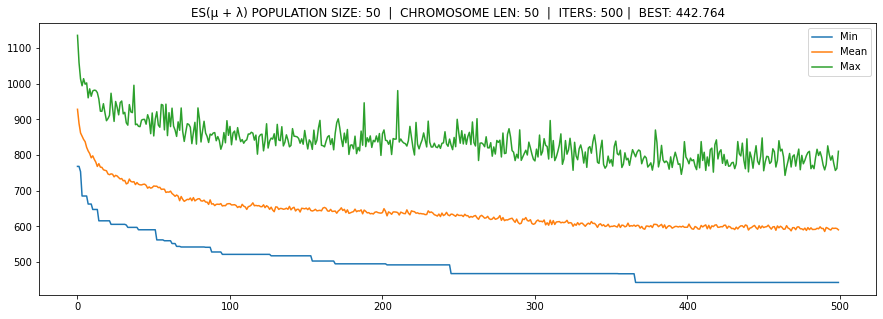

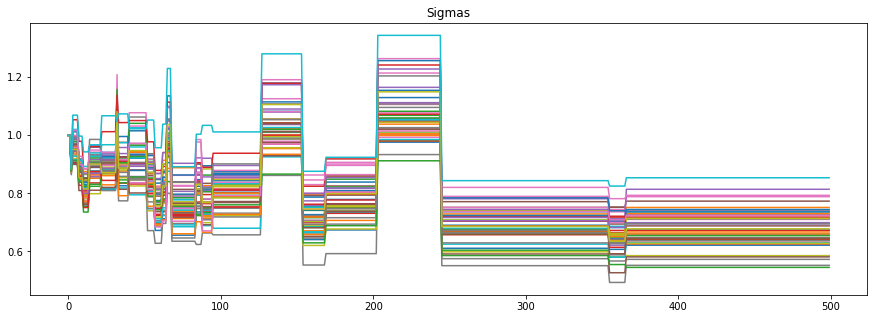

ES(µ + λ): 100%|██████████| 500/500 [00:18<00:00, 26.85it/s]


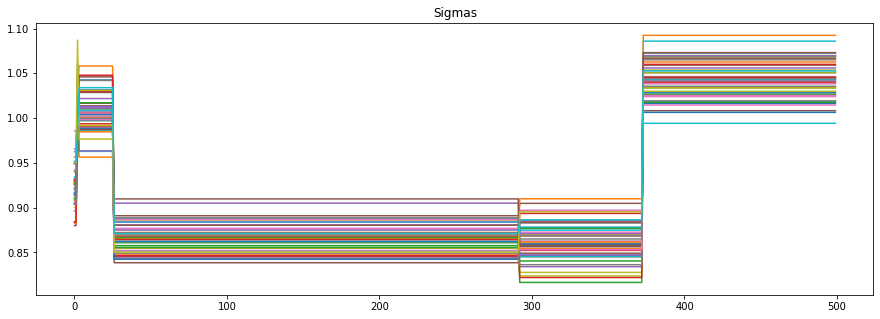

ES(µ, λ): 100%|██████████| 1000/1000 [00:49<00:00, 20.31it/s]


ES(µ + λ): 100%|██████████| 1000/1000 [00:52<00:00, 19.15it/s]


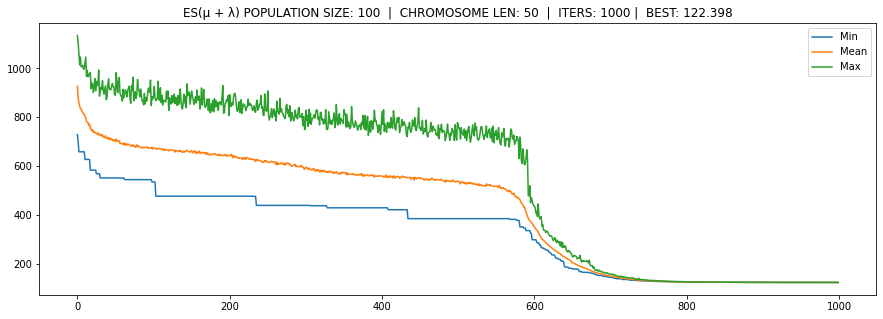

ES(µ + λ):   1%|          | 3/500 [00:00<00:17, 29.21it/s]

Dixon-Price Function


ES(µ + λ): 100%|██████████| 500/500 [00:17<00:00, 28.06it/s]


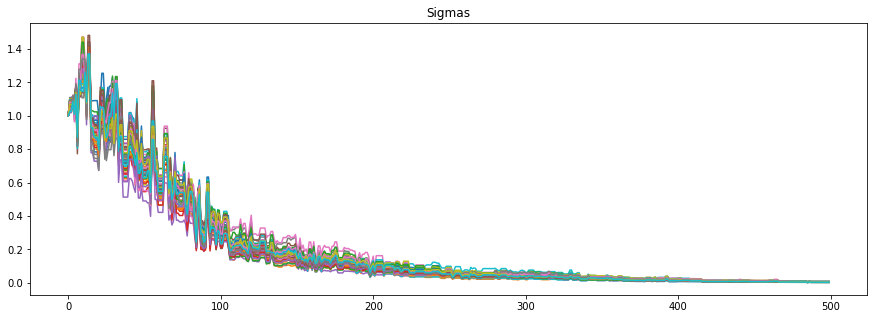

ES(µ + λ): 100%|██████████| 500/500 [00:18<00:00, 26.66it/s]


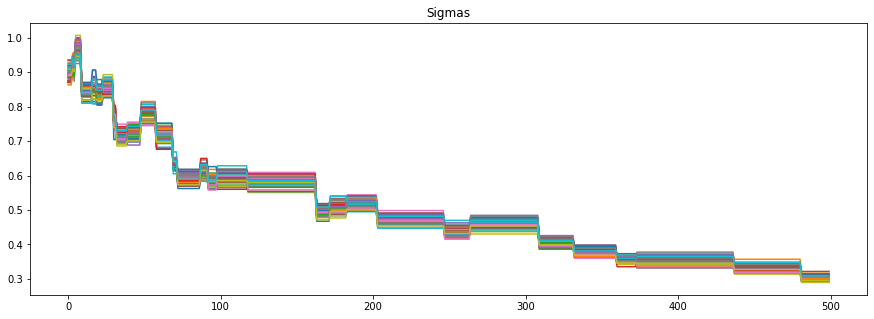

ES(µ, λ): 100%|██████████| 1000/1000 [00:52<00:00, 18.98it/s]


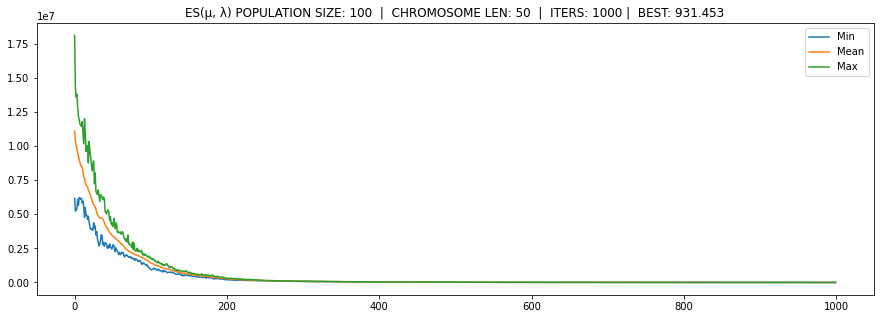

ES(µ + λ): 100%|██████████| 1000/1000 [00:49<00:00, 20.21it/s]


In [7]:
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5], 
                 instances[i][6], instances[i][7], instances[i][8],
                 instances[i][9])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])


In [24]:
instances = [
    'Griewank Function', 
    (0, 2000, 1500, 2000, 50, griewank, -600, 600, 0.5, False),
    (0, 2000, 1500, 2000, 50, griewank, -600, 600, 0.5, True),
    'Michalewicz Function', 
    (0, 2000, 1500, 2000, 50, michalewicz, 0, np.pi, 0.5, False),
    (0, 2000, 1500, 2000, 50, michalewicz, 0, np.pi, 0.5, True),
    'Rastrigin Function',
    (0, 2000, 1500, 2000, 50, rastrigin, -5.12, 5.12, 0.5, False),
    (0, 2000, 1500, 2000, 50, rastrigin, -5.12, 5.12, 0.5, True),
    'Dixon-Price Function',
    (0, 2000, 1500, 2000, 50, dixon_price, -10, 10, 0.5, False),
    (0, 2000, 1500, 2000, 50, dixon_price, -10, 10, 0.5, True)
]


ES(µ + λ):   0%|          | 0/2000 [00:00<?, ?it/s]

Griewank Function


ES(µ + λ): 100%|██████████| 2000/2000 [31:34<00:00,  1.06it/s]


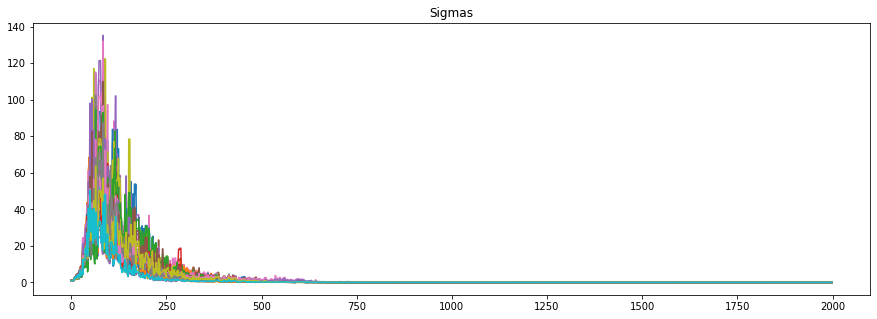

ES(µ + λ): 100%|██████████| 2000/2000 [24:05<00:00,  1.38it/s]


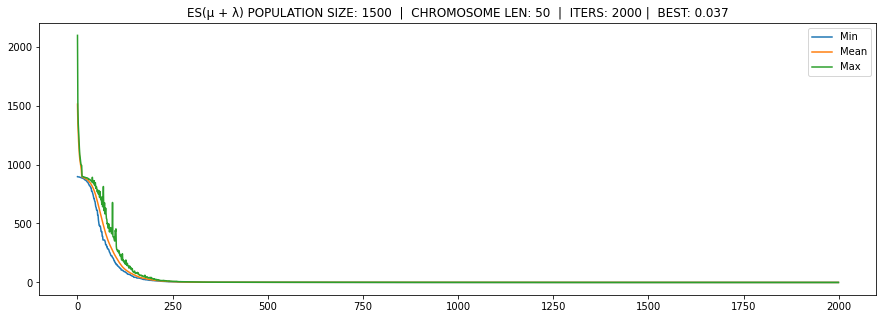

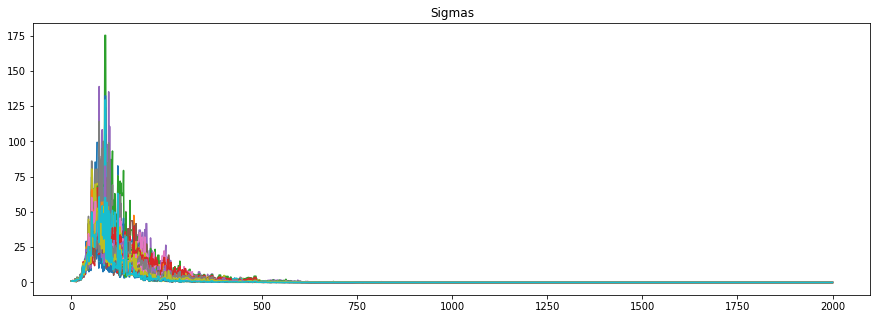

ES(µ + λ):   0%|          | 0/2000 [00:00<?, ?it/s]

Michalewicz Function


ES(µ + λ): 100%|██████████| 2000/2000 [23:32<00:00,  1.42it/s]


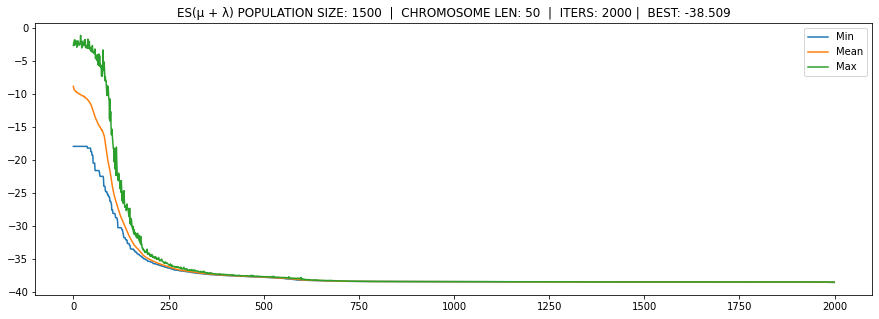

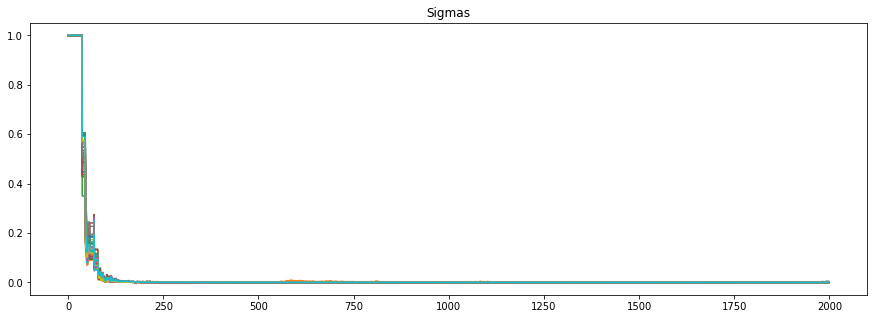

ES(µ + λ): 100%|██████████| 2000/2000 [24:49<00:00,  1.34it/s]


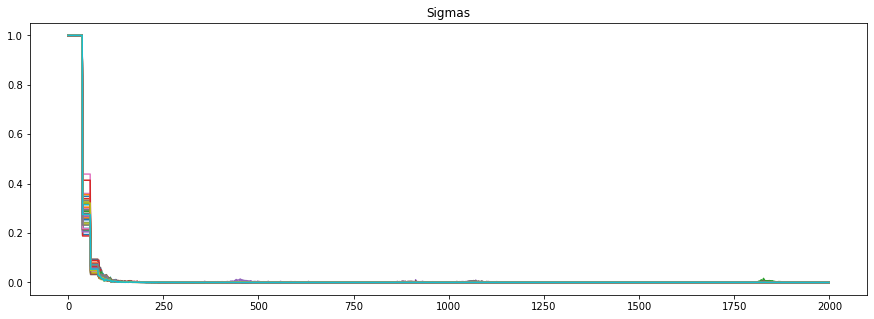

ES(µ + λ):   0%|          | 0/2000 [00:00<?, ?it/s]

Rastrigin Function


ES(µ + λ): 100%|██████████| 2000/2000 [20:58<00:00,  1.59it/s]


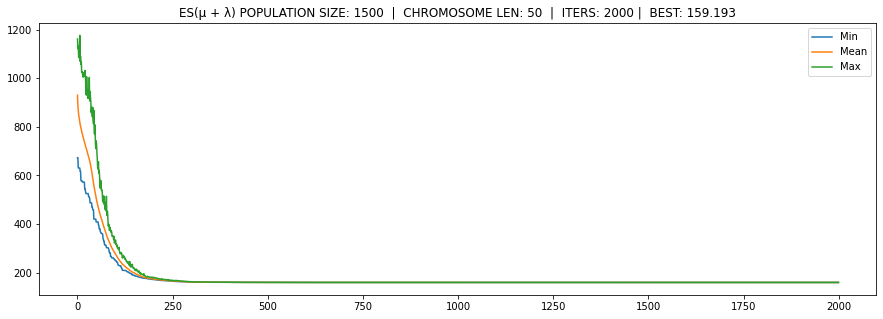

ES(µ + λ): 100%|██████████| 2000/2000 [20:53<00:00,  1.60it/s]


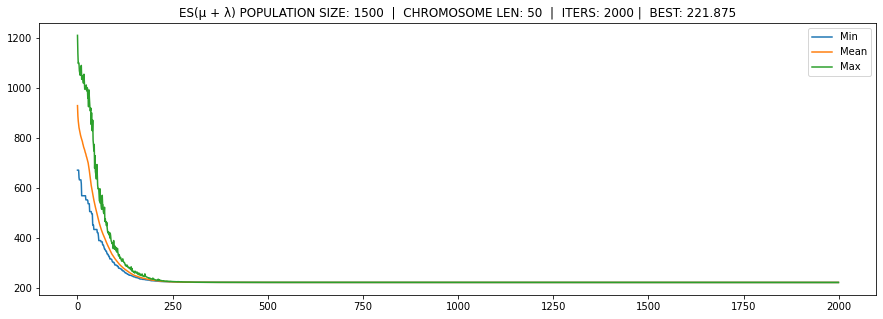

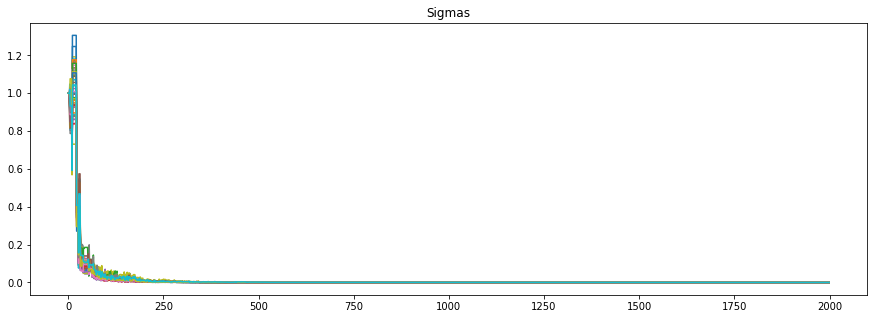

ES(µ + λ):   0%|          | 0/2000 [00:00<?, ?it/s]

Dixon-Price Function


ES(µ + λ): 100%|██████████| 2000/2000 [21:38<00:00,  1.54it/s]


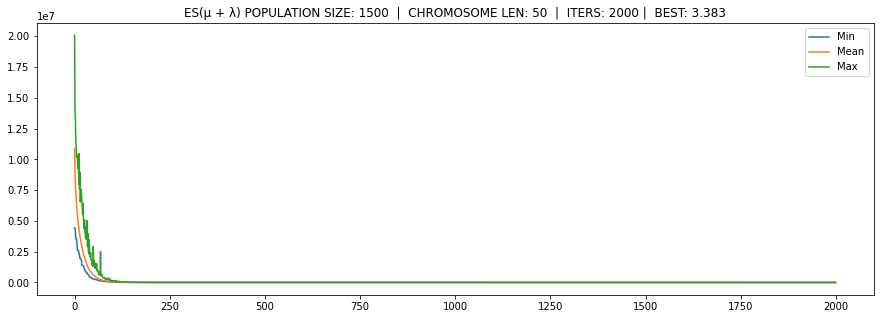

ES(µ + λ): 100%|██████████| 2000/2000 [21:40<00:00,  1.54it/s]


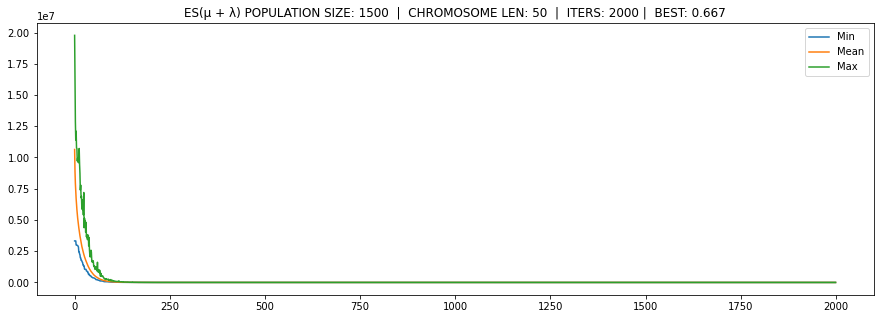

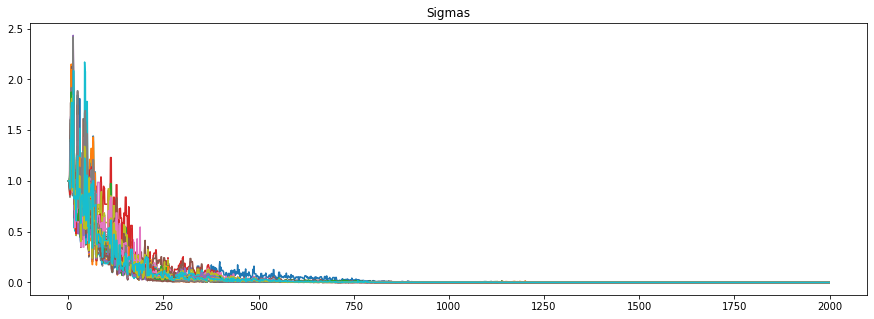

In [25]:
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5],
                 instances[i][6], instances[i][7], instances[i][8])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])


# Task 2

In [22]:
penalty = 1000000
epsilon = 1e-2

def G3(x):
    ans = 0
    n = len(x)
    if abs(np.sum(x**2) - n) > epsilon:
        ans += penalty
    return ans-(np.sqrt(n)**n * np.prod(x))


def G13(x):
    ans = 0
    if abs(np.sum(x[:5]**2) - 10) > epsilon:
        ans = penalty
    if abs(x[1]*x[2] - 5*x[3]*x[4]) > epsilon:
        ans = penalty
    if abs(x[0]**3 + x[1]**3 + 1) > epsilon:
        ans = penalty
    return ans + np.exp(np.prod(x))


def G2(x):
    ans = 0
    if -np.prod(x) + 0.75 > 0:
        ans = penalty
    if np.sum(x) - 7.5*len(x) > 0:
        ans = penalty

    return ans-(abs((np.sum(np.cos(x)**4) - 2*np.prod(np.cos(x)**2))/np.sqrt(np.sum((np.arange(len(x)) + 1)*(x**2)))))


def G8(x):
    ans = 0
    if x[0]**2 - x[1] + 1 > 0:
        ans = penalty
    if 1 - x[0] + (x[1]-4)**2 > 0:
        ans = penalty

    return ans + (np.sin(2*np.pi*x[0])**3 * np.sin(2*np.pi*x[1]))/(x[0]**3 * (x[0] + x[1]))


def G11(x):
    ans = 0
    if abs(x[1]-x[0]**2) > epsilon:
        ans = penalty
    return x[0]**2 + (x[1] - 1)**2 + ans


In [18]:
instances = [
    'G2 - OPT: 0.803619',
    (0, 1000, 1500, 2000, 20, G2, 0, 10, 0.3),
    'G3 - OPT: 1',
    (0, 1000, 1500, 2000, 10, G3, 0, 1, 0.3),
    'G8 - OPT: 0.095825',
    (0, 1000, 1500, 2000, 2, G8, 0.0001, 10, 0.3),
    'G11 - OPT: 0.75',
    (0, 1000, 1500, 2000, 2, G11, -1, 1, 0.3),
    'G13 - OPT: 0.0539498',
    (0, 1000, 1500, 2000, 5, G13, -2, 2, 0.3),
]


ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G2 - OPT: 0.803619


ES(µ + λ): 100%|██████████| 1000/1000 [13:41<00:00,  1.22it/s]


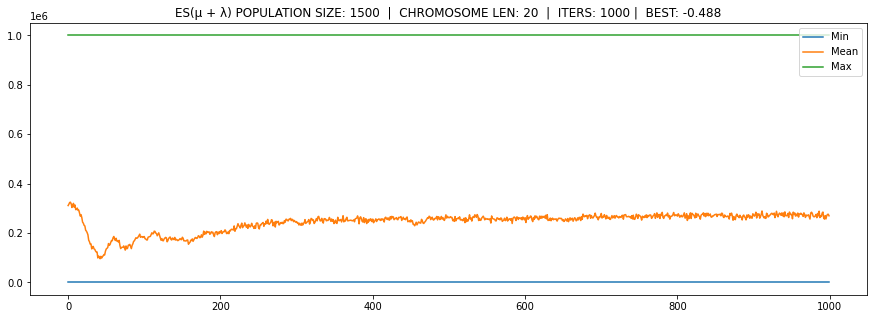

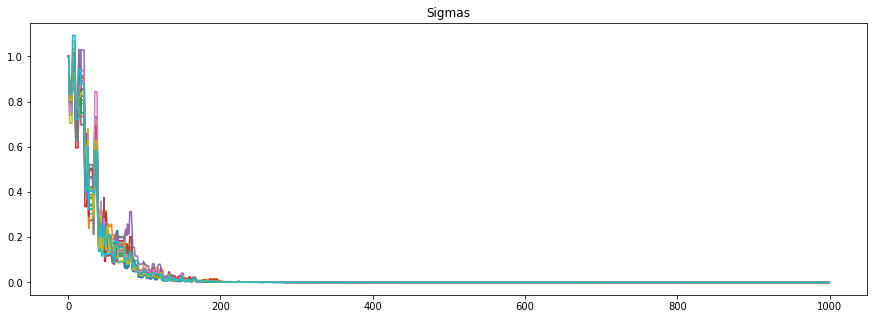

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G3 - OPT: 1


ES(µ + λ): 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


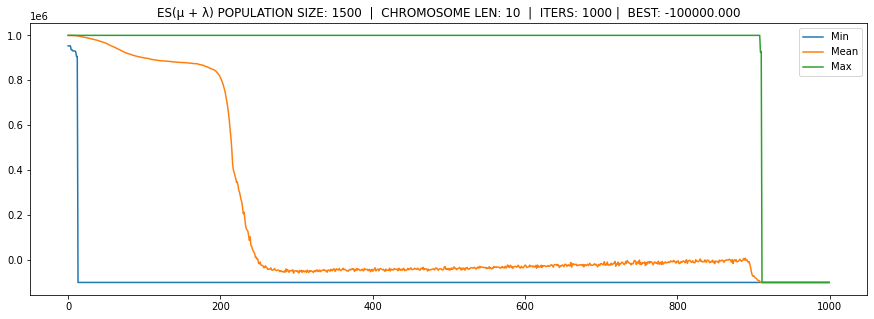

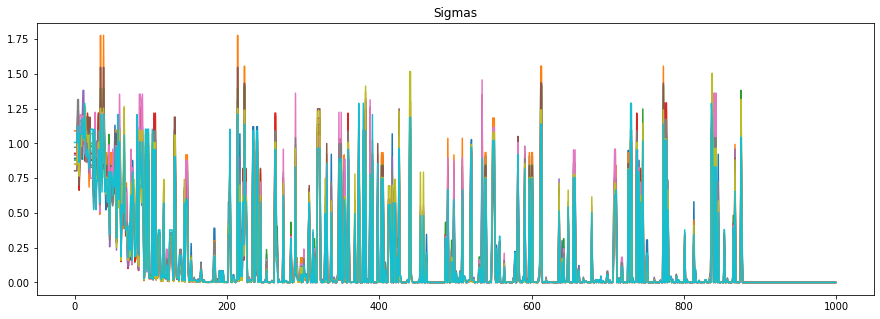

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G8 - OPT: 0.095825


ES(µ + λ): 100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]


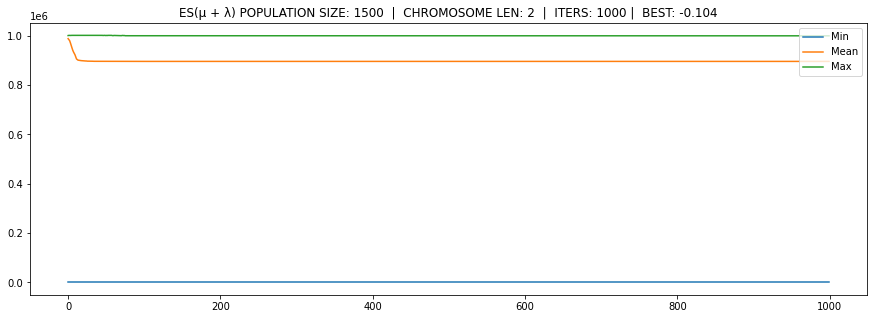

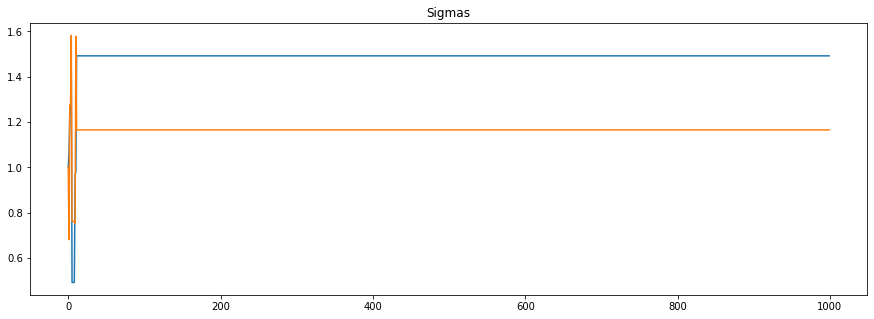

ES(µ + λ):   0%|          | 1/1000 [00:00<02:05,  7.95it/s]

G11 - OPT: 0.75


ES(µ + λ): 100%|██████████| 1000/1000 [02:27<00:00,  6.76it/s]


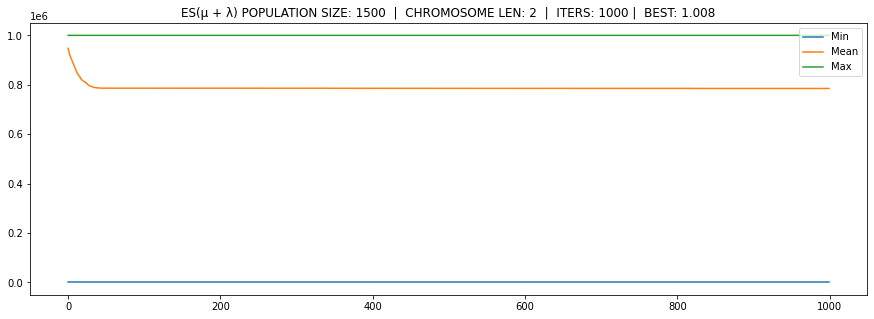

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G13 - OPT: 0.0539498


ES(µ + λ): 100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


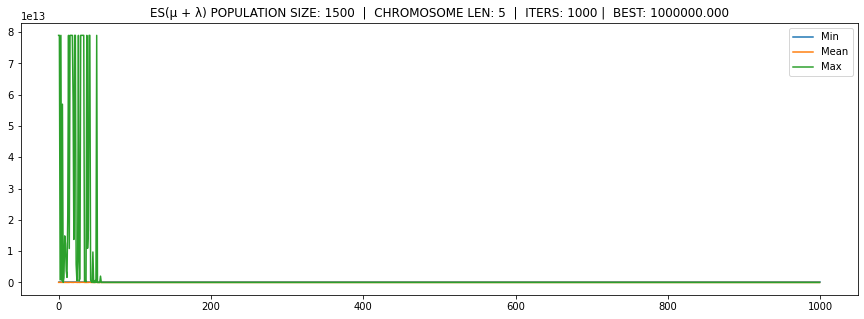

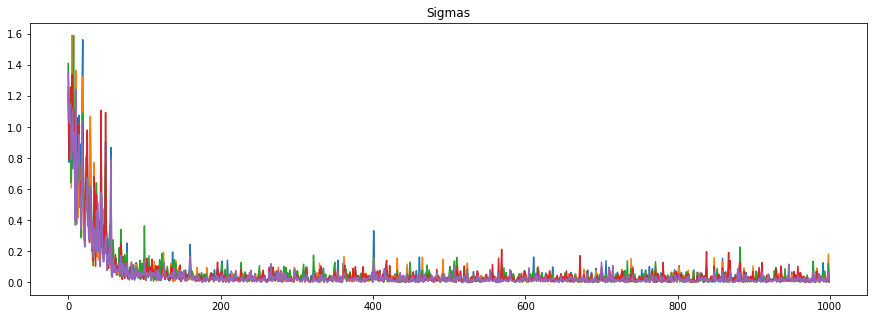

In [20]:
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5],
                 instances[i][6], instances[i][7], instances[i][8])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])


ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G3 - OPT: 1


ES(µ + λ): 100%|██████████| 1000/1000 [04:22<00:00,  3.82it/s]


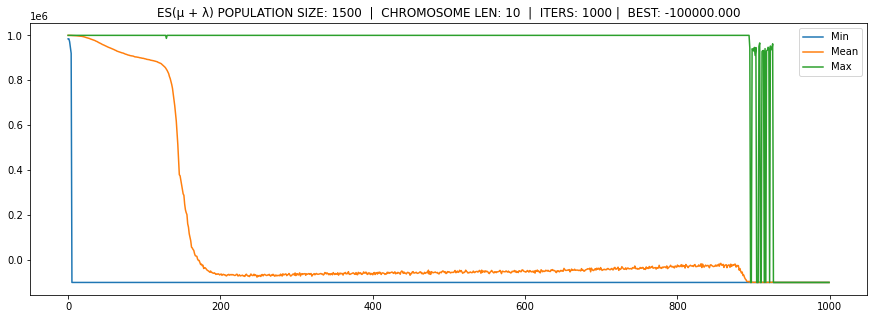

ES(µ + λ):   0%|          | 1/1000 [00:00<02:42,  6.13it/s]

G11 - OPT: 0.75


ES(µ + λ): 100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


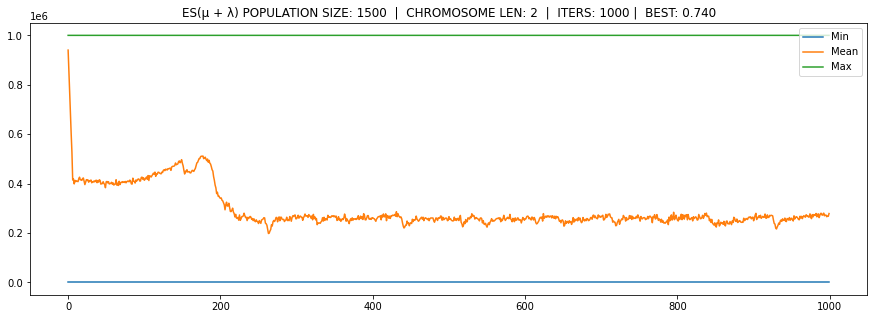

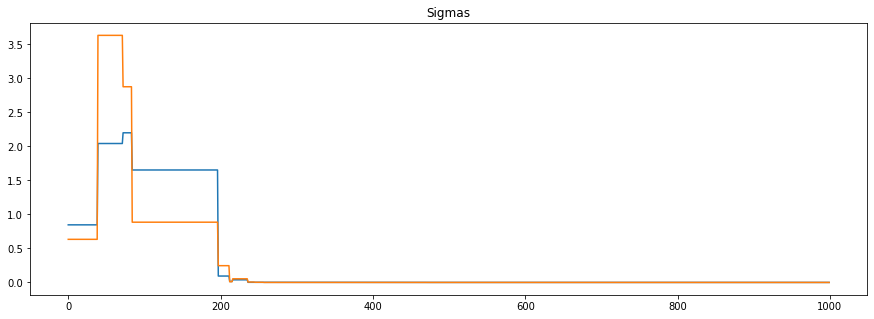

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G13 - OPT: 0.0539498


ES(µ + λ): 100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]


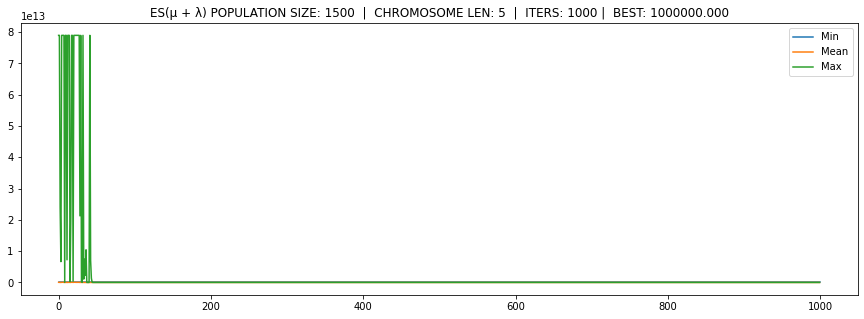

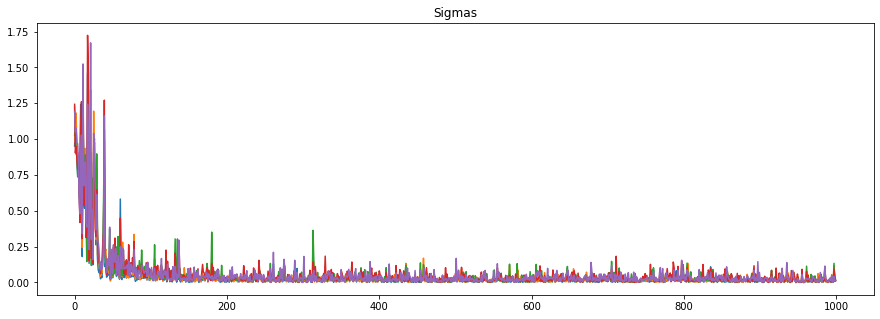

In [23]:
instances = [
    'G3 - OPT: 1',
    (0, 1000, 1500, 2000, 10, G3, 0, 1, 0.3),
    'G11 - OPT: 0.75',
    (0, 1000, 1500, 2000, 2, G11, -1, 1, 0.3),
    'G13 - OPT: 0.0539498',
    (0, 1000, 1500, 2000, 5, G13, -2, 2, 0.3),
]
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5],
                 instances[i][6], instances[i][7], instances[i][8])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])


ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G2 - OPT: 0.803619


ES(µ + λ): 100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


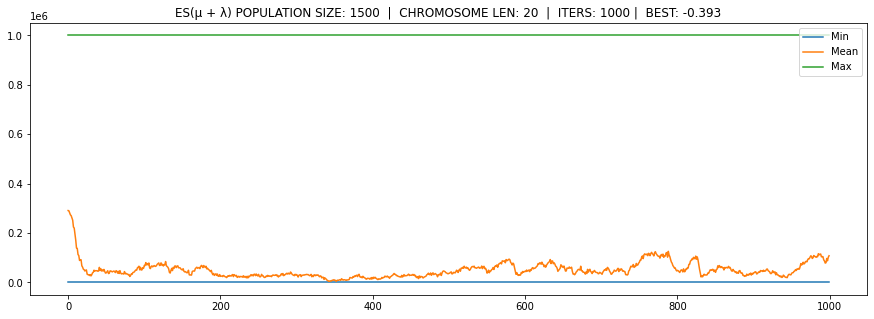

ES(µ + λ):   0%|          | 1/1000 [00:00<01:57,  8.50it/s]

G8 - OPT: 0.095825


ES(µ + λ): 100%|██████████| 1000/1000 [01:55<00:00,  8.62it/s]


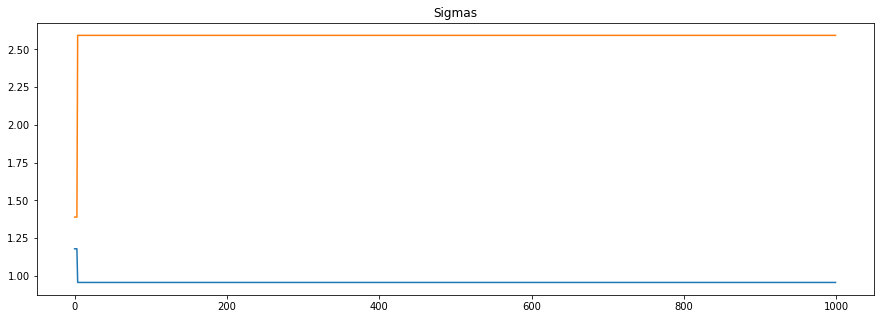

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

G11 - OPT: 0.75


ES(µ + λ): 100%|██████████| 1000/1000 [01:34<00:00, 10.62it/s]


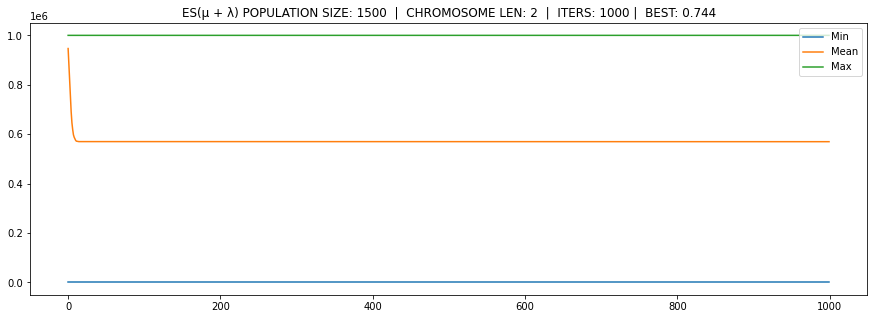

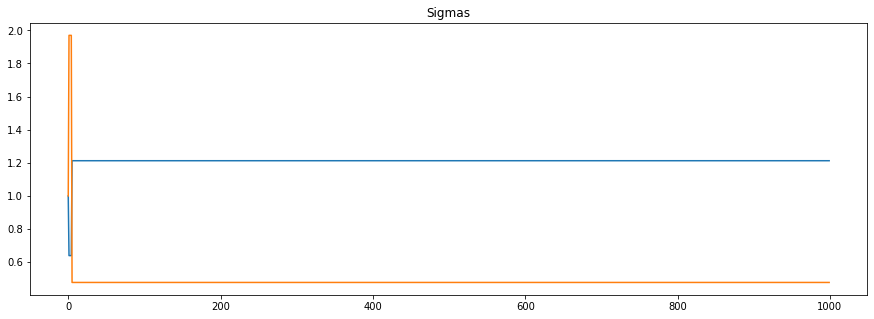

In [26]:
instances = [
    'G2 - OPT: 0.803619',
    (0, 1000, 1500, 1500, 20, G2, 0, 10, 1),
    'G8 - OPT: 0.095825',
    (0, 1000, 1500, 1500, 2, G8, 0.0001, 10, 1),
    'G11 - OPT: 0.75',
    (0, 1000, 1500, 1500, 2, G11, -1, 1, 1),
]
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5],
                 instances[i][6], instances[i][7], instances[i][8])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])


# Task 3

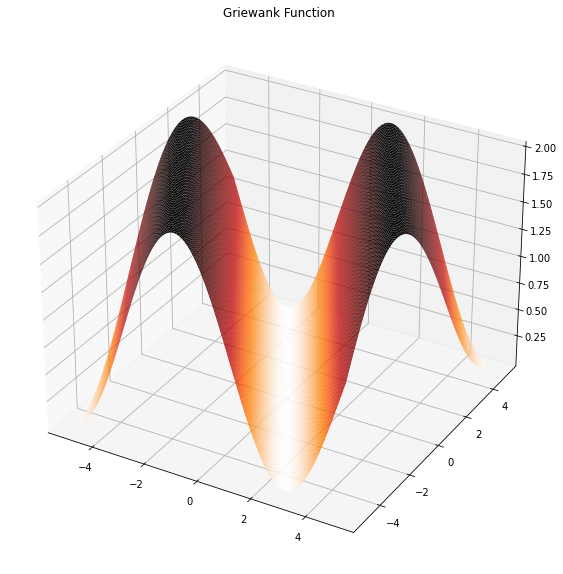

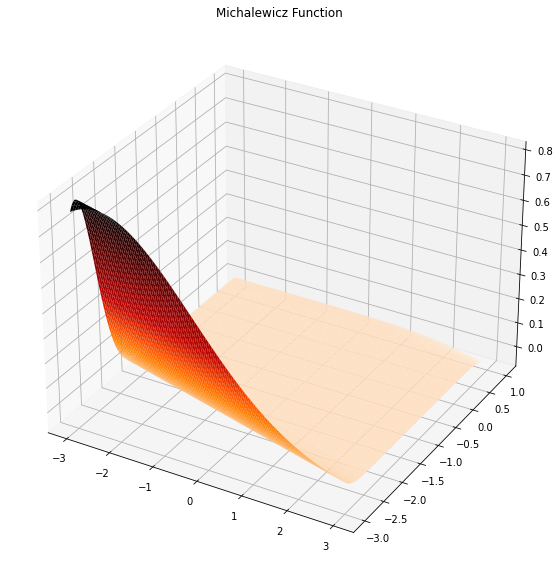

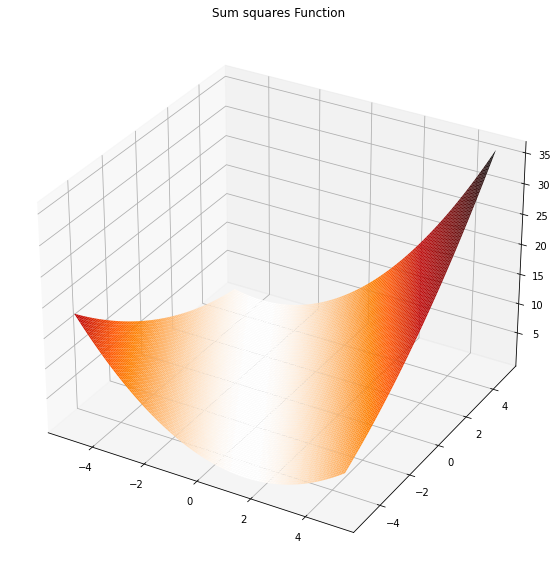

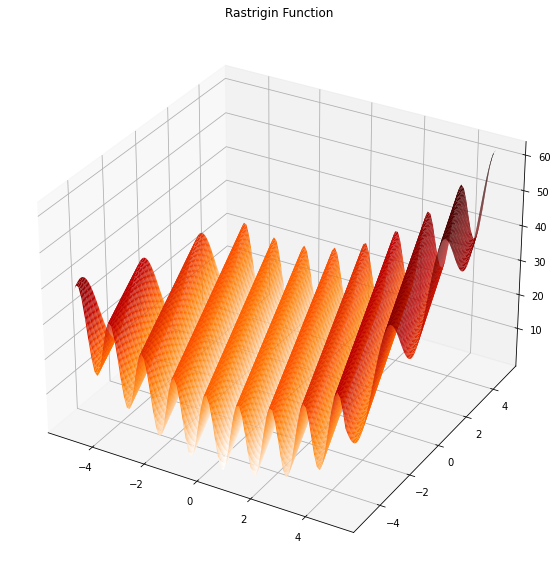

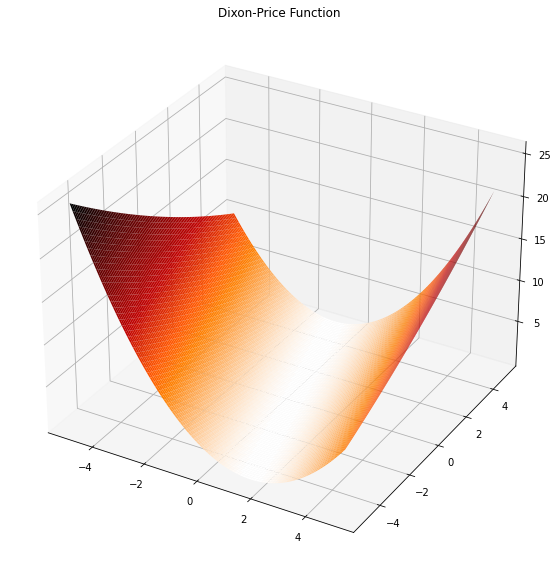

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

h = 10d
Griewank Function


ES(µ + λ): 100%|██████████| 1000/1000 [10:19<00:00,  1.62it/s]


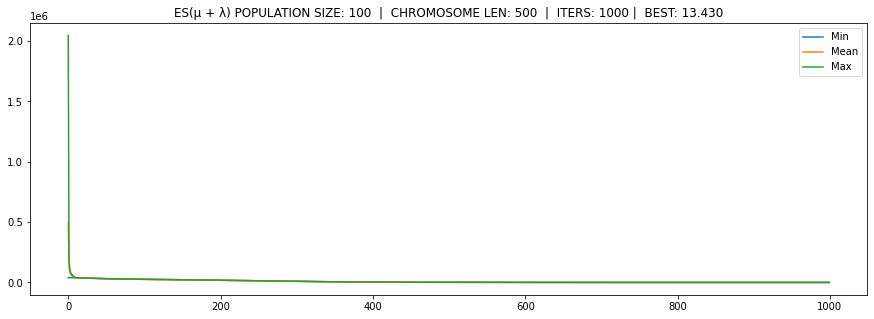

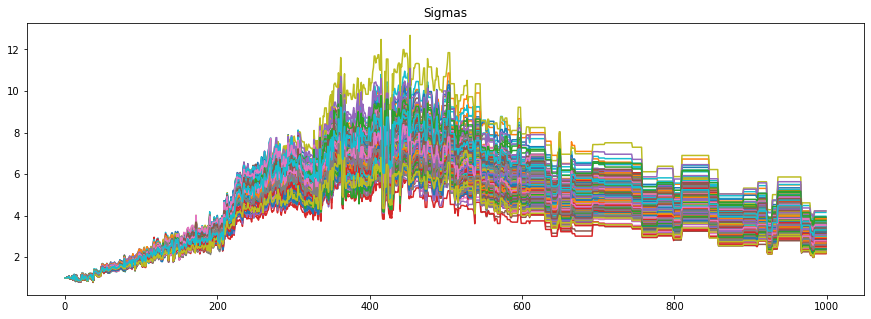

ES(µ + λ): 100%|██████████| 2500/2500 [1:05:10<00:00,  1.56s/it]


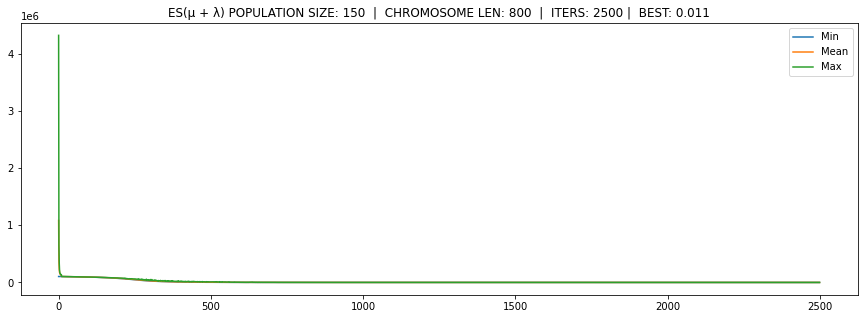

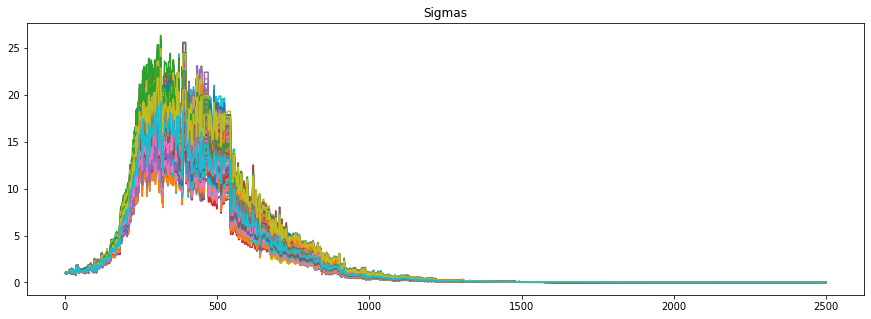

ES(µ + λ):   0%|          | 1/1000 [00:00<01:54,  8.70it/s]

Michalewicz Function


ES(µ + λ): 100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


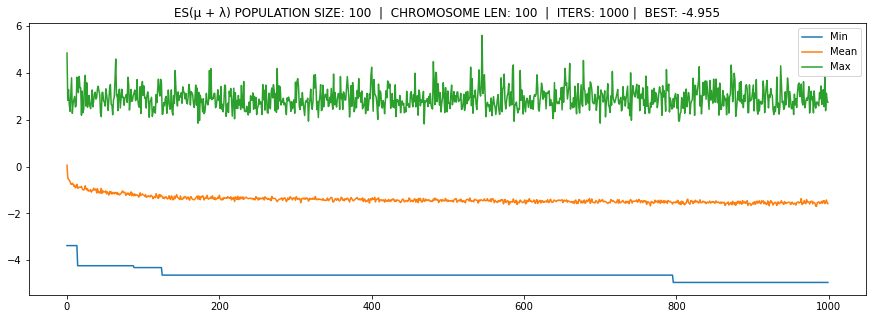

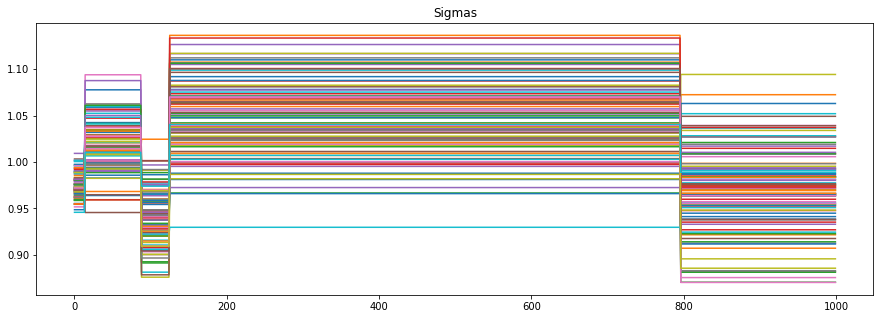

ES(µ + λ): 100%|██████████| 2500/2500 [33:43<00:00,  1.24it/s]


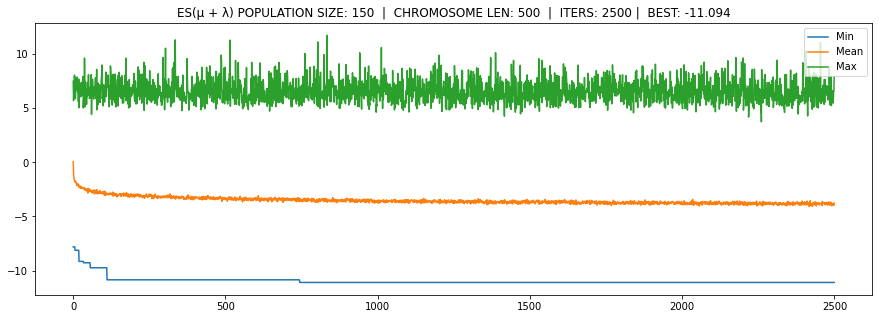

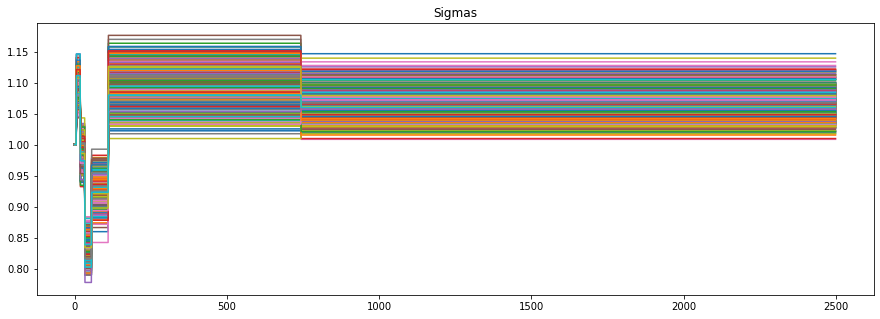

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

Sum squares Function


ES(µ + λ): 100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s]


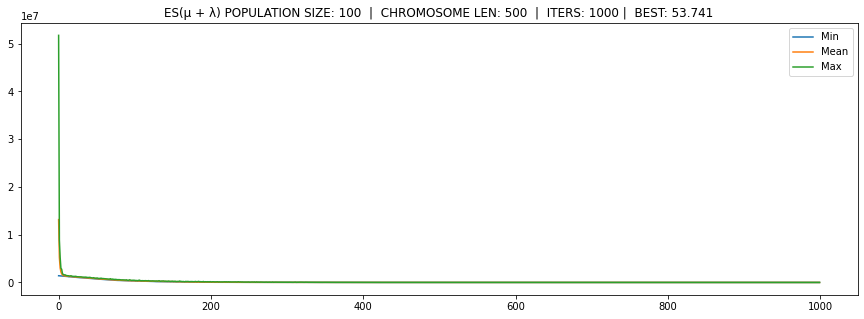

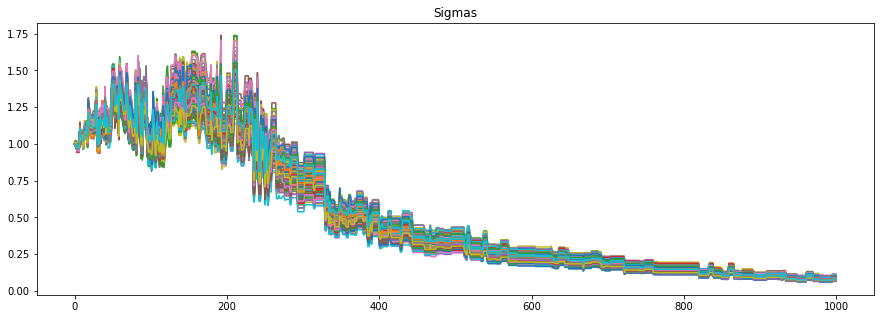

ES(µ + λ): 100%|██████████| 2500/2500 [57:24<00:00,  1.38s/it]


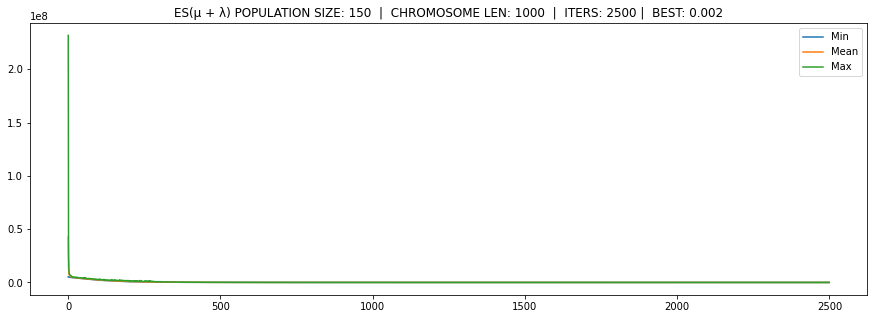

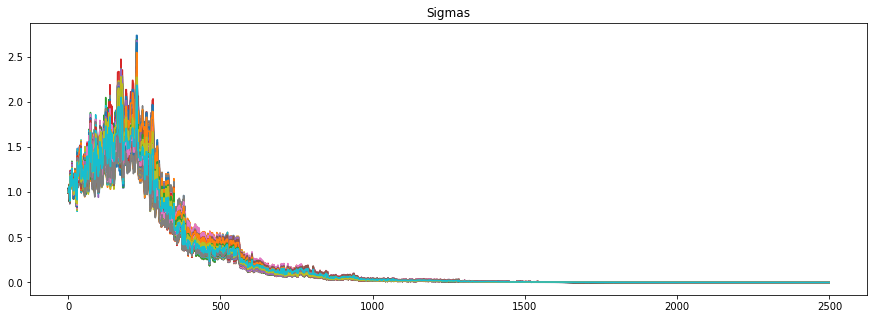

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

Rastrigin Function


ES(µ + λ): 100%|██████████| 1000/1000 [04:09<00:00,  4.02it/s]


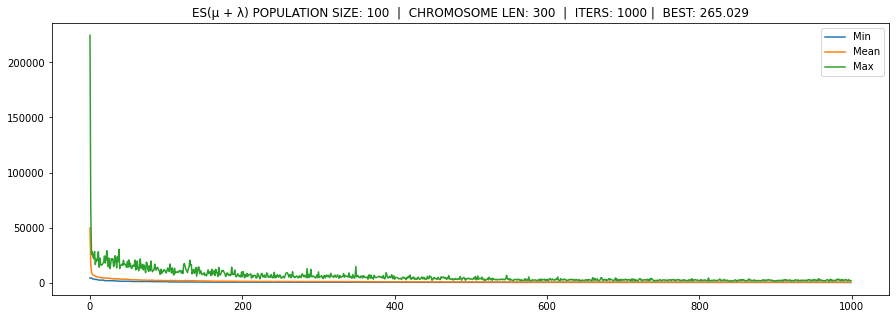

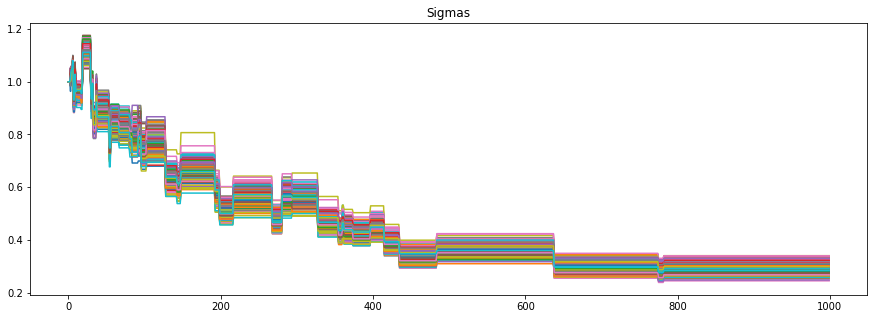

ES(µ + λ): 100%|██████████| 2500/2500 [29:38<00:00,  1.41it/s]


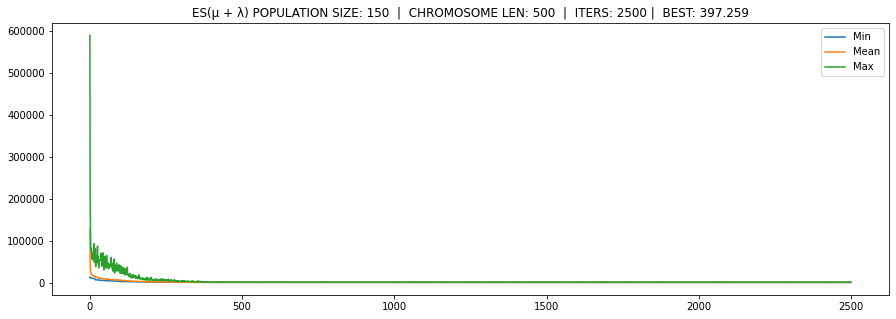

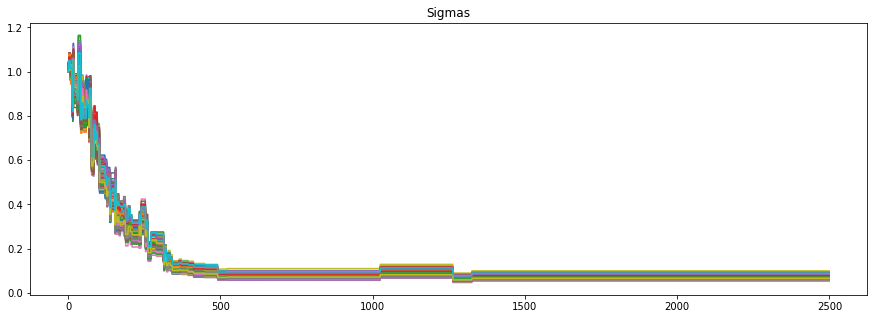

ES(µ + λ):   0%|          | 0/1000 [00:00<?, ?it/s]

Dixon-Price Function


ES(µ + λ): 100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]


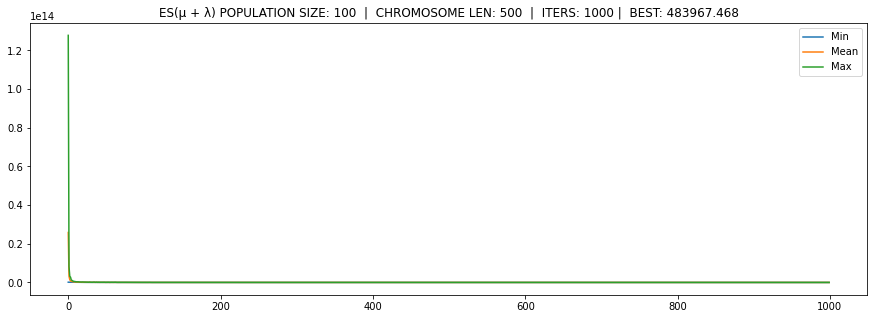

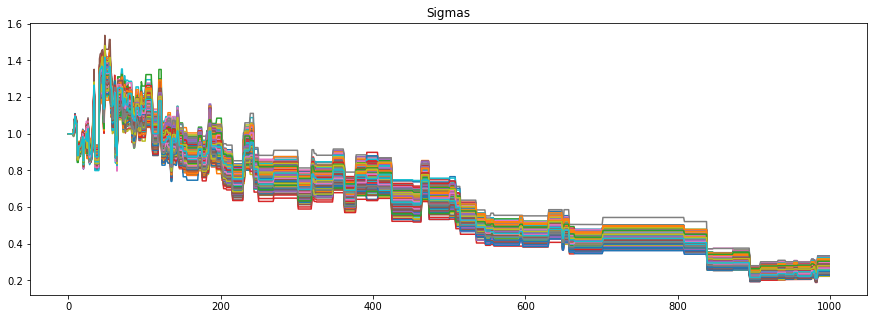

ES(µ + λ): 100%|██████████| 2500/2500 [45:53<00:00,  1.10s/it]


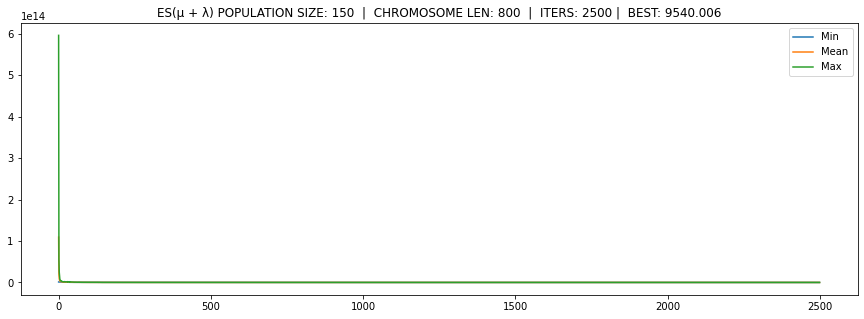

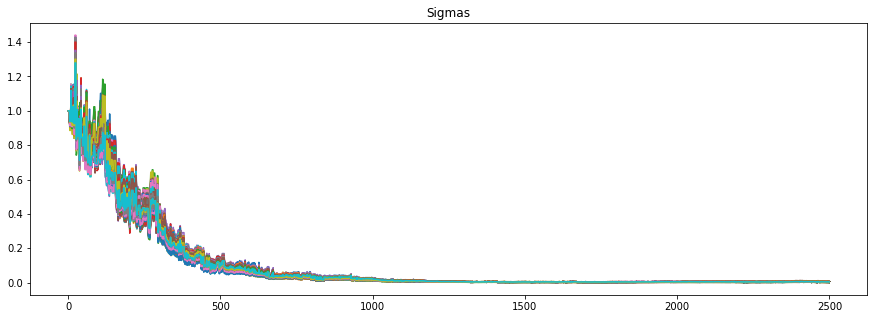

ES(µ + λ):   0%|          | 1/1000 [00:00<01:41,  9.80it/s]

h = d
Griewank Function


ES(µ + λ): 100%|██████████| 1000/1000 [00:57<00:00, 17.48it/s]


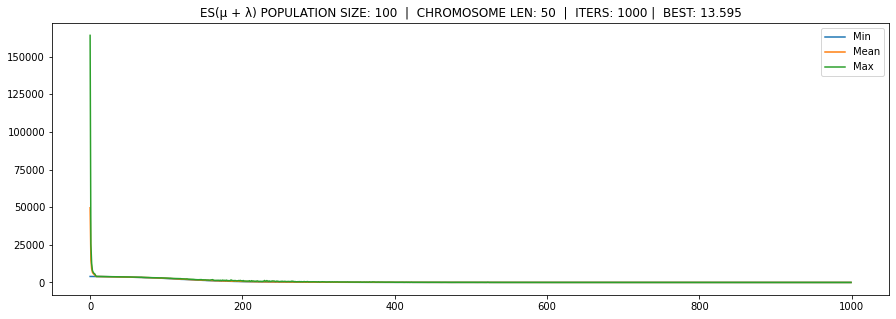

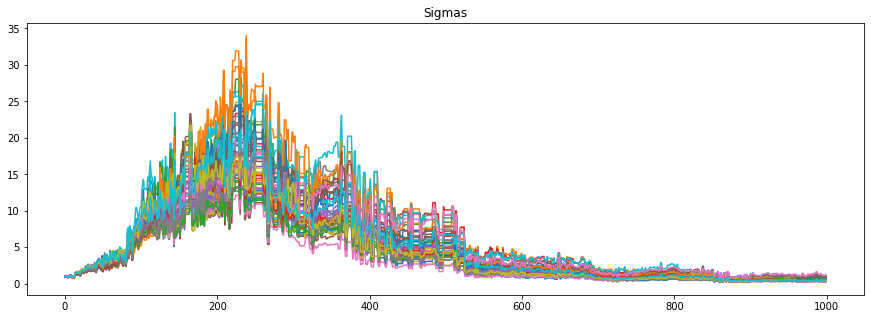

ES(µ + λ): 100%|██████████| 2500/2500 [04:30<00:00,  9.23it/s]


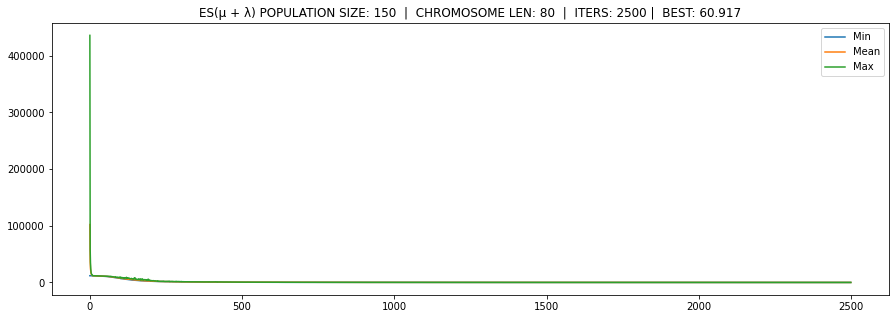

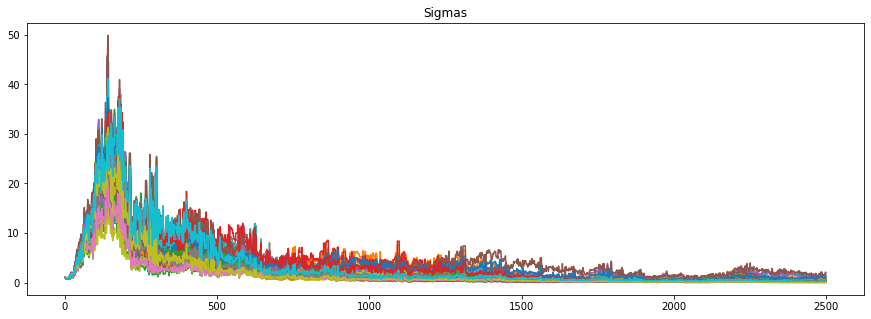

ES(µ + λ):   0%|          | 4/1000 [00:00<00:25, 39.09it/s]

Michalewicz Function


ES(µ + λ): 100%|██████████| 1000/1000 [00:20<00:00, 48.78it/s]


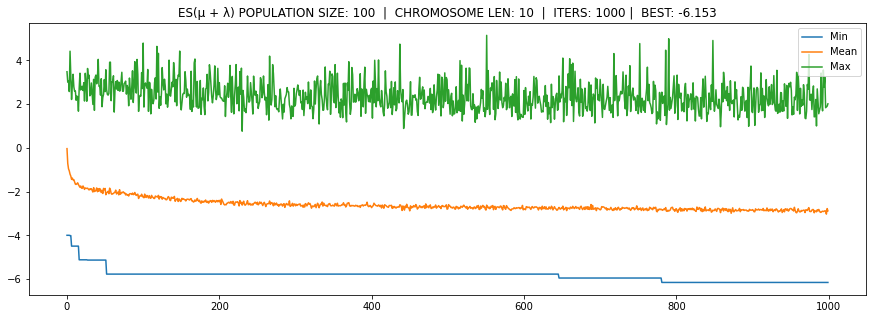

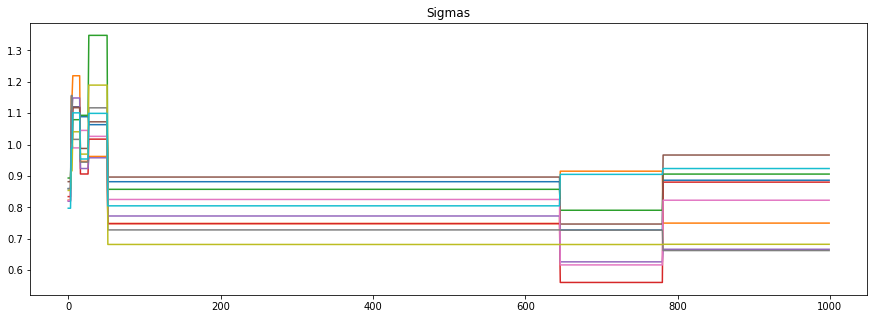

ES(µ + λ): 100%|██████████| 2500/2500 [02:58<00:00, 14.04it/s]


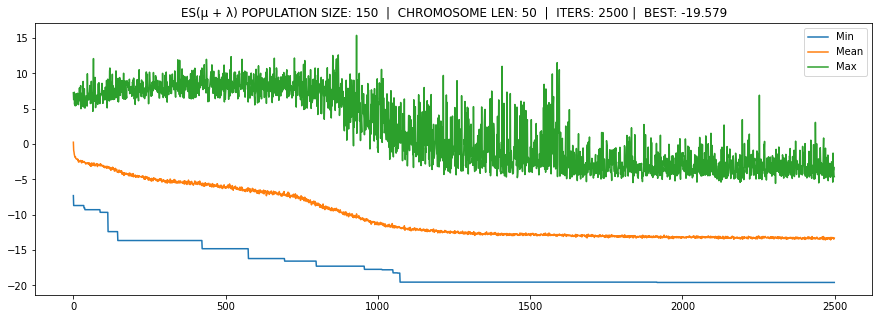

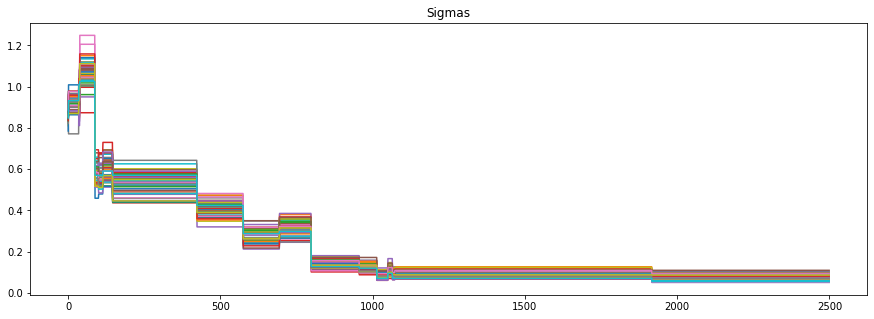

ES(µ + λ):   0%|          | 2/1000 [00:00<01:21, 12.31it/s]

Sum squares Function


ES(µ + λ): 100%|██████████| 1000/1000 [00:48<00:00, 20.75it/s]


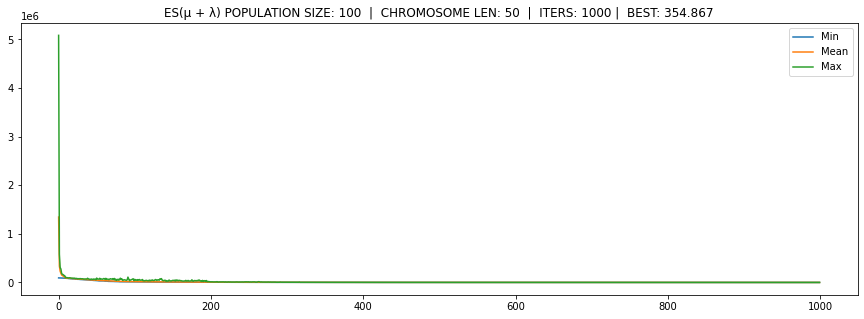

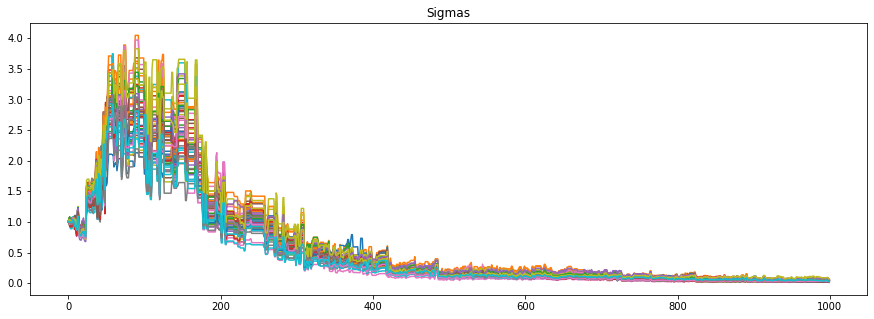

ES(µ + λ): 100%|██████████| 2500/2500 [11:23<00:00,  3.66it/s]


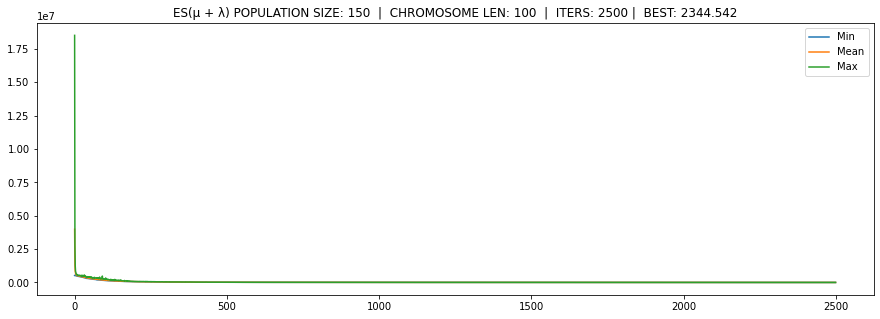

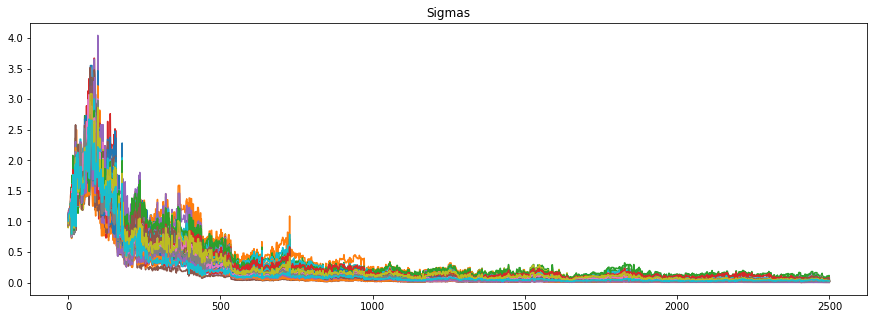

ES(µ + λ):   0%|          | 2/1000 [00:00<00:52, 18.91it/s]

Rastrigin Function


ES(µ + λ): 100%|██████████| 1000/1000 [00:33<00:00, 29.61it/s]


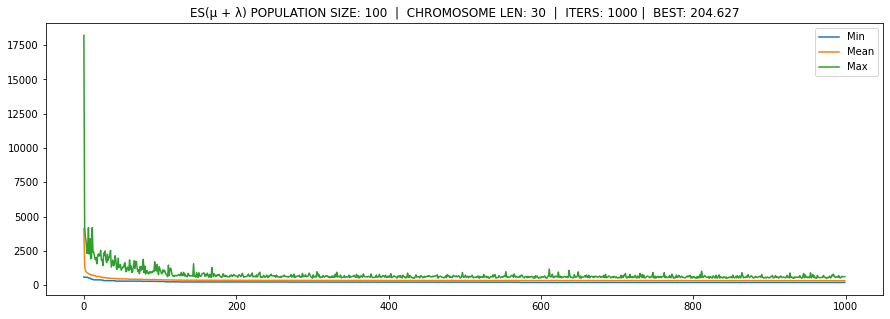

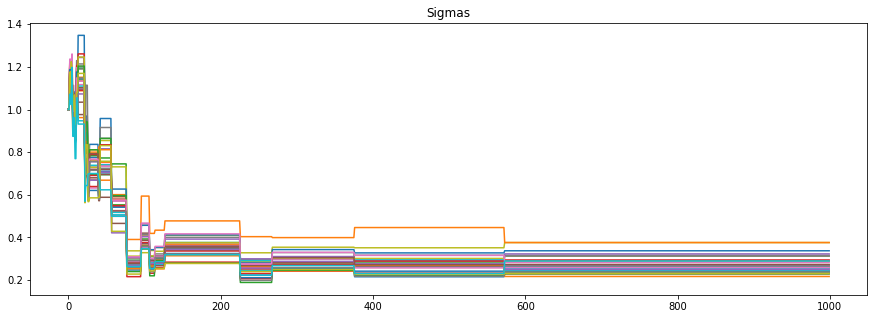

ES(µ + λ): 100%|██████████| 2500/2500 [02:45<00:00, 15.11it/s]


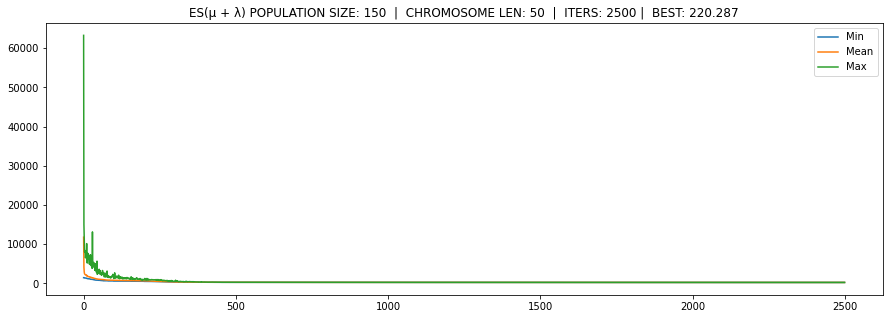

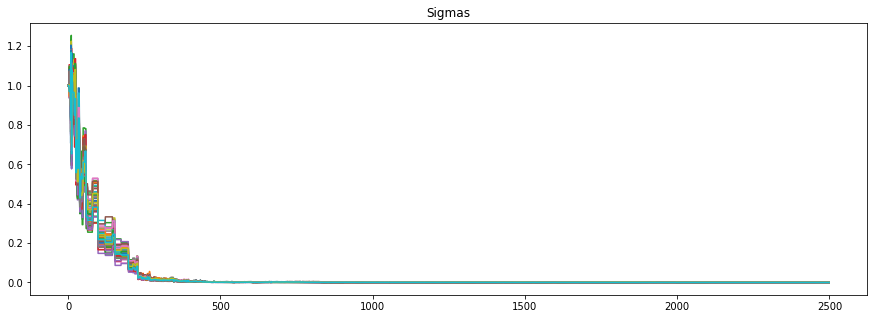

ES(µ + λ):   0%|          | 2/1000 [00:00<01:08, 14.56it/s]

Dixon-Price Function


ES(µ + λ): 100%|██████████| 1000/1000 [00:50<00:00, 19.87it/s]


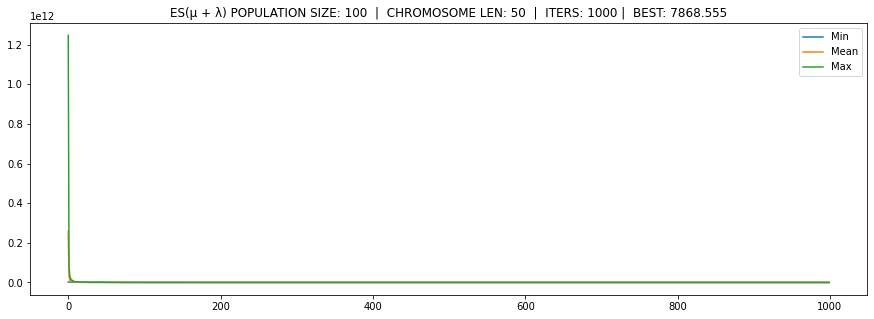

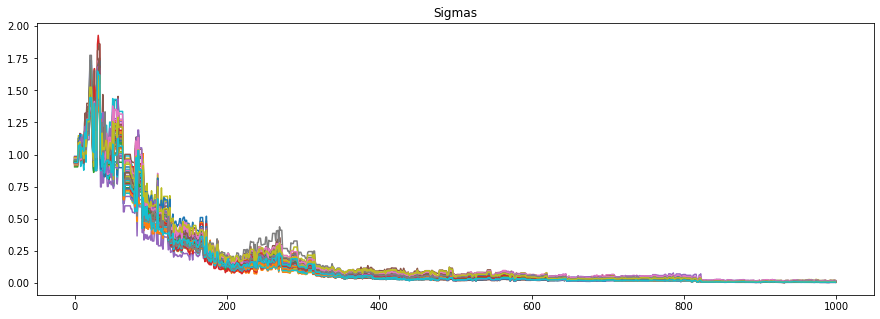

ES(µ + λ): 100%|██████████| 2500/2500 [04:03<00:00, 10.28it/s]


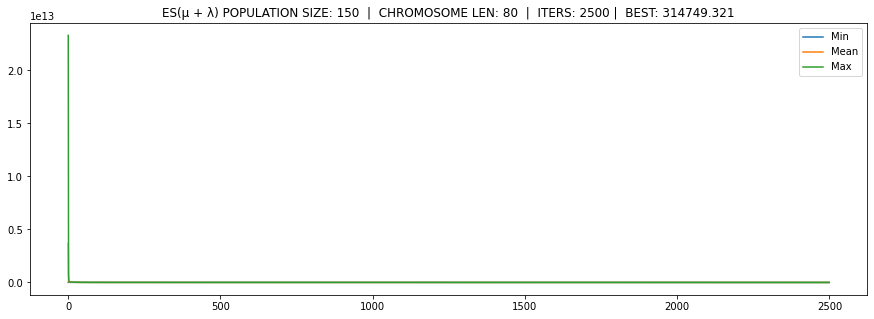

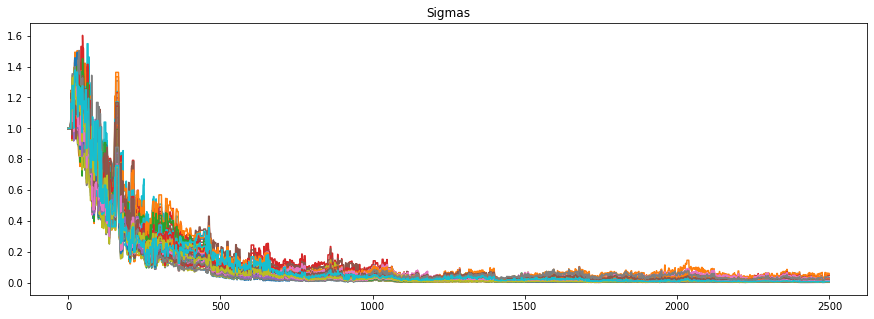

In [12]:
def modify_benchmark(function, h, d):
    A = np.random.rand(d, h)
    b = np.random.rand(d)
    def G(y):
        return function(A@y+b)
    return G


plot_3D_benchmark_function(
    modify_benchmark(griewank, 2, 1), np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Griewank Function')
plot_3D_benchmark_function(
    modify_benchmark(michalewicz, 2, 1), np.linspace(-3, 3, 100),  np.linspace(-3, 1, 100), 'Michalewicz Function')
plot_3D_benchmark_function(
    modify_benchmark(sum_squares, 2, 1), np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Sum squares Function')
plot_3D_benchmark_function(
    modify_benchmark(rastrigin, 2, 1), np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Rastrigin Function')
plot_3D_benchmark_function(
    modify_benchmark(dixon_price, 2, 1), np.linspace(-5, 5, 100),  np.linspace(-5, 5, 100), 'Dixon-Price Function')

instances = [
    'h = 10d',
    'Griewank Function',
    (0, 1000, 100, 150, 50*10, modify_benchmark(griewank, 50*10, 50), -600, 600, 0.2),
    (0, 2500, 150, 200, 80*10, modify_benchmark(griewank, 80*10, 80), -600, 600, 0.3),
    'Michalewicz Function',
    (0, 1000, 100, 150, 10*10, modify_benchmark(michalewicz, 10*10, 10), 0, np.pi, 0.2),
    (0, 2500, 150, 200, 50*10, modify_benchmark(michalewicz, 50*10, 50), 0, np.pi, 0.3),
    'Sum squares Function',
    (0, 1000, 100, 150, 50*10, modify_benchmark(sum_squares, 50*10, 50), -50, 50, 0.2),
    (0, 2500, 150, 200, 100*10, modify_benchmark(sum_squares, 100*10, 100), -50, 50, 0.3),
    'Rastrigin Function',
    (0, 1000, 100, 150, 30*10, modify_benchmark(rastrigin, 30*10, 30), -5.12, 5.12, 0.2),
    (0, 2500, 150, 200, 50*10, modify_benchmark(rastrigin, 50*10, 50), -5.12, 5.12, 0.3),
    'Dixon-Price Function',
    (0, 1000, 100, 150, 50*10, modify_benchmark(dixon_price, 50*10, 50), -20, 20, 0.2),
    (0, 2500, 150, 200, 80*10, modify_benchmark(dixon_price, 80*10, 80), -20, 20, 0.3),
    'h = d',
    'Griewank Function',
    (0, 1000, 100, 150, 50, modify_benchmark(griewank, 50, 50), -600, 600, 0.2),
    (0, 2500, 150, 200, 80, modify_benchmark(griewank, 80, 80), -600, 600, 0.3),
    'Michalewicz Function',
    (0, 1000, 100, 150, 10, modify_benchmark(michalewicz, 10, 10), 0, np.pi, 0.2),
    (0, 2500, 150, 200, 50, modify_benchmark(michalewicz, 50, 50), 0, np.pi, 0.3),
    'Sum squares Function',
    (0, 1000, 100, 150, 50, modify_benchmark(sum_squares, 50, 50), -50, 50, 0.2),
    (0, 2500, 150, 200, 100, modify_benchmark(sum_squares, 100, 100), -50, 50, 0.3),
    'Rastrigin Function',
    (0, 1000, 100, 150, 30, modify_benchmark(rastrigin, 30, 30), -5.12, 5.12, 0.2),
    (0, 2500, 150, 200, 50, modify_benchmark(rastrigin, 50, 50), -5.12, 5.12, 0.3),
    'Dixon-Price Function',
    (0, 1000, 100, 150, 50, modify_benchmark(dixon_price, 50, 50), -20, 20, 0.2),
    (0, 2500, 150, 200, 80, modify_benchmark(dixon_price, 80, 80), -20, 20, 0.3),
]
for i in range(len(instances)):
    if type(instances[i]) != str:
      model = ES(instances[i][0], instances[i][1], instances[i][2],
                 instances[i][3], instances[i][4], instances[i][5],
                 instances[i][6], instances[i][7], instances[i][8])
      model.run()
      model.plot_cost()
      model.plot_sigmas(model.best_sigmas_history)
    else:
        print(instances[i])
